In [1]:
import numpy as np
import opendssdirect as dss
from utils.device.Inverter import Inverter
from utils.controller.AdaptiveInvController import AdaptiveInvController
from utils.controller.FixedInvController import FixedInvController
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time

%matplotlib inline

# import numpy as np
# from matplotlib.mlab import PCA
from sklearn.decomposition import PCA

import scipy.linalg as spla

#######################################################
#######################################################

Sbase=1
LoadScalingFactor = 3
GenerationScalingFactor = 5

SlackBusVoltage = 1.00

#######################################################
#######################################################


dss.run_command('Redirect feeder/03node_multiphase_balanced.dss')
# dss.run_command('Redirect feeder/feeder34_B_NR/network_05node_3phase_radial.dss')

dss.Solution.Solve()
if not dss.Solution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

print(dss.Loads.AllNames())
print(len(dss.Loads.AllNames()))

print(dss.Circuit.AllBusNames())
print(len(dss.Circuit.AllBusNames()))

print('')

print(dss.RegControls.AllNames())

for k1 in range(len(dss.RegControls.AllNames())):
    print(dss.RegControls.AllNames()[k1])
    dss.RegControls.Name(dss.RegControls.AllNames()[k1])
    
    print(dss.RegControls.TapNumber())
    
print('')

for k1 in range(len(dss.Circuit.AllBusNames())):
    dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
    print(dss.Circuit.AllBusNames()[k1])
    print('BASE - LN')
    print(dss.Bus.kVBase())
    print('VMAGANGLE - LN POLAR')
    print(dss.Bus.VMagAngle()[::2])
    print('puVMAGANGLE - LN POLAR')
    print(dss.Bus.puVmagAngle()[::2])
    print('')

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
['s701a', 's701b', 's701c', 's702a', 's702b', 's702c']
6
['sourcebus', '799', '799r', '701', '702']
5

['reg1']
reg1
6

sourcebus
BASE - LN
132.79056191361394
VMAGANGLE - LN POLAR
[132789.7205425955, 132789.65745154137, 132789.6561144716]
puVMAGANGLE - LN POLAR
[0.9999936639245567, 0.9999931888075513, 0.9999931787385393]

799
BASE - LN
2.7712812921102037
VMAGANGLE - LN POLAR
[2662.7871789654087, 2653.122744951476, 2653.122715163918]
puVMAGANGLE - LN POLAR
[0.9608505591064769, 0.9573632068692834, 0.9573631961206244]

799r
BASE - LN
2.7712812921102037
VMAGANGLE - LN POLAR
[2762.529518327461, 2752.4981632837626, 2752.4981323776656]
puVMAGANGLE - LN POLAR
[0.9968419756566543, 0.9932222221973943, 0.9932222110451171]

701
BASE - LN
2.7712812921102037
VMAGANGLE - LN POLAR
[2728.6832832548525, 2689.9528261197506, 2689.9527943186677]
puVMAGANGLE - LN POLAR
[0.9846287675752631, 0.9706531176672704, 0.970653106192043

In [2]:
#######################################################
#######################################################
####         Load data from file                    ###
#######################################################
#######################################################

#Retrieving the data from the load profile
TimeResolutionOfData = 10 #resolution in minute
#Get the data from the Testpvnum folder
#Provide Your Directory - move testpvnum10 from github to drive C: 
FileDirectoryBase ='../Data Files/testpvnum10/'
QSTS_Time = list(range(1441)) #This can be changed based on the available data - for example, 1440 timesteps
QSTS_Data = np.zeros((len(QSTS_Time),4,TotalLoads)) #4 columns as there are four columns of data available in the .mat file

for node in range(TotalLoads):
    #This is created manually according to the naming of the folder
    FileDirectoryExtension = 'node_' + str(node+1) + '_pv_' +str(TimeResolutionOfData) + '_minute.csv'
    #The total file directory
    FileName = FileDirectoryBase + FileDirectoryExtension
    #Load the file
    MatFile = np.genfromtxt(FileName, delimiter=',')    
    QSTS_Data[:,:,node] = MatFile #Putting the loads to appropriate nodes according to the loadlist
    
Generation = QSTS_Data[:,1,:]*GenerationScalingFactor #solar generation
Load = QSTS_Data[:,3,:]*LoadScalingFactor #load demand
Generation = np.squeeze(Generation)/Sbase  #To convert to per unit, it should not be multiplied by 100
Load = np.squeeze(Load)/Sbase
print('Reading Data for Pecan Street is done.')

Generation[Generation <= 0] = 0
Load[Load <= 0] = 0

Generation_minutes = Generation
Load_minutes = Load

len(Load[:,0])

Reading Data for Pecan Street is done.


1441

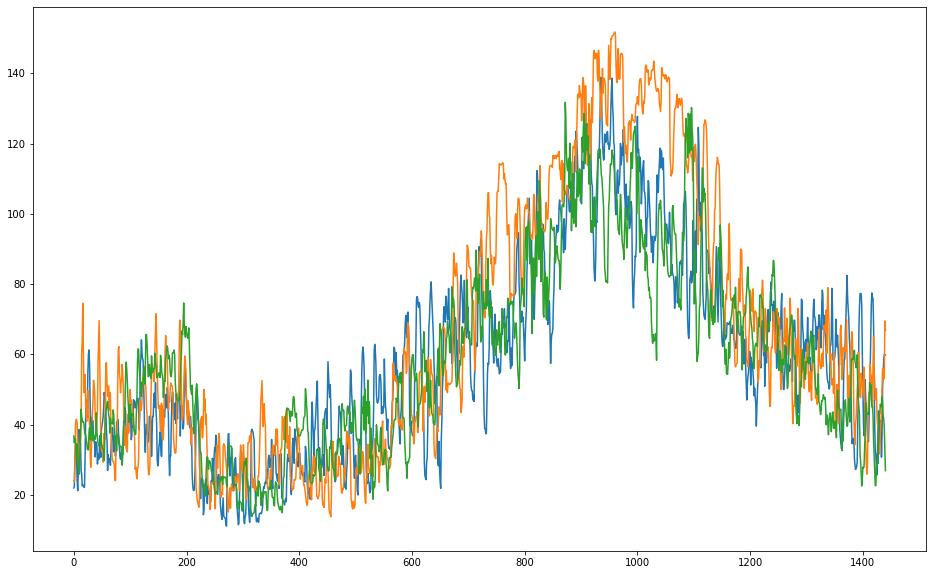

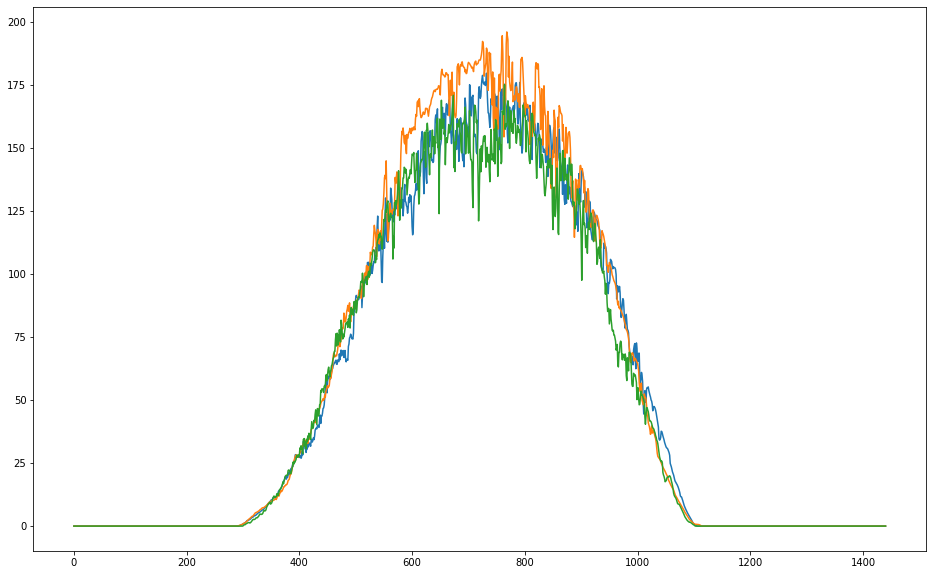

In [3]:
fig = plt.figure(figsize=[16,10])
for k1 in range(0, 3):
    plt.plot(Load[:,k1])
    
fig = plt.figure(figsize=[16,10])
for k1 in range(0, 3):
    plt.plot(Generation[:,k1])

In [4]:
############################################################
############################################################
#### Interpolate to change data from minutes to seconds ####
############################################################
############################################################

StartTime = 0
EndTime = StartTime + 86400
EndTime += 1

from scipy.interpolate import interp1d

print('Starting Interpolation...')

#interpolation for the whole period...
Time = list(range(StartTime,EndTime))
TotalTimeSteps = len(Time)
LoadSeconds = np.empty([3600*24 + 1, TotalLoads])
GenerationSeconds = np.empty([3600*24 + 1, TotalLoads])
# Interpolate to get minutes to seconds
for node in range(TotalLoads): # i is node
    
    t_seconds = np.linspace(0,len(Load_minutes[:,node]),int(3600*24 + 1))
        
    f = interp1d(np.arange(len(Load_minutes[:,node])), Load_minutes[:,node], kind='cubic', fill_value="extrapolate")
    LoadSeconds[:,node] = f(t_seconds) #spline method in matlab equal to Cubic Spline -> cubic
    
#     print(np.arange(len(Load_minutes[:,node])))
#     print(t_seconds)
    
    f = interp1d(np.arange(len(Generation_minutes[:,node])), Generation_minutes[:,node], kind='cubic', fill_value="extrapolate")
    GenerationSeconds[:,node]= f(t_seconds)
    
# Initialization
# then we take out only the window we want...
# LoadSeconds = LoadSeconds[StartTime:EndTime,:]
# GenerationSeconds = GenerationSeconds[StartTime:EndTime,:]
Load = LoadSeconds
Generation = GenerationSeconds
timeList = list(range(TotalTimeSteps))
print('Finished Interpolation!')

print(len(t_seconds))
print(len(Load_minutes[:,node]))

Load.shape

Starting Interpolation...
Finished Interpolation!
86401
1441


(86401, 6)

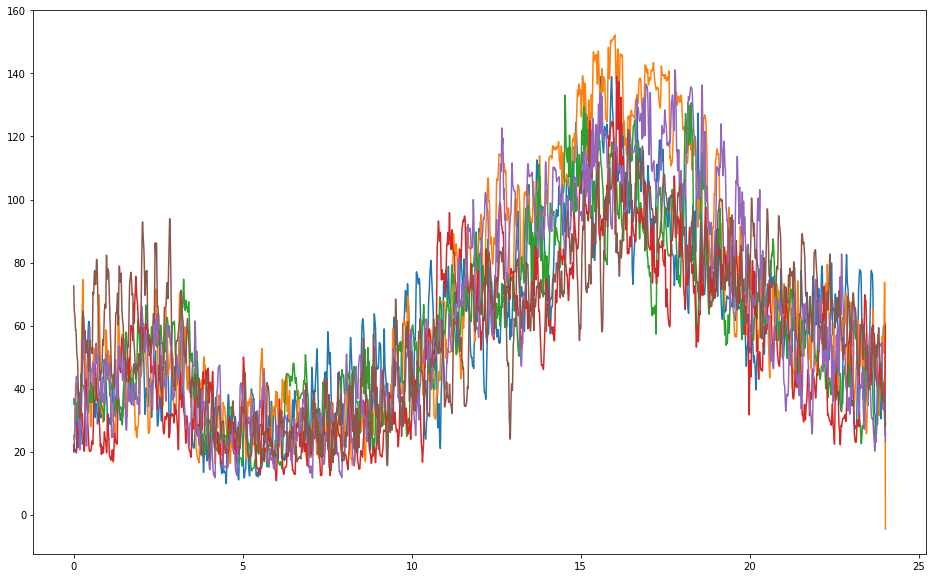

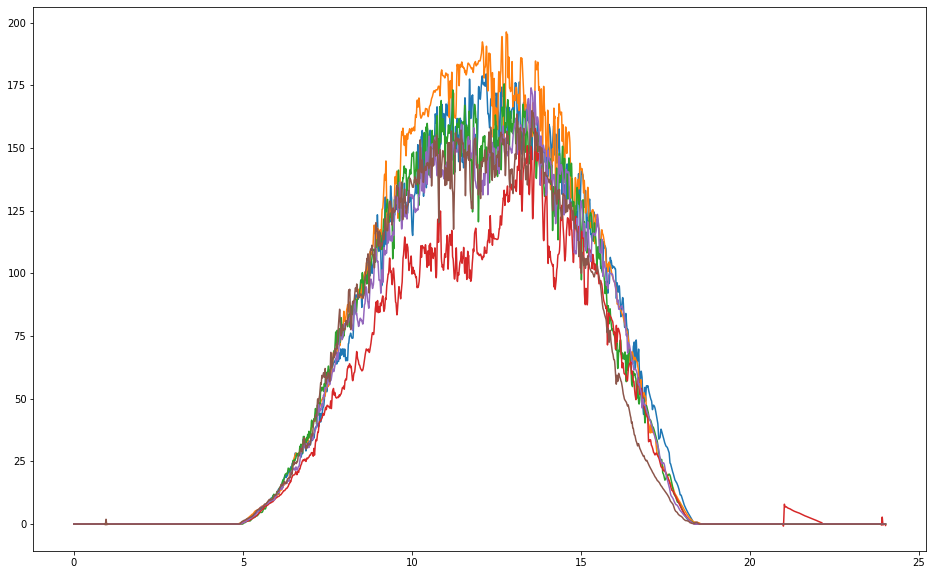

In [5]:
fig = plt.figure(figsize=[16,10])
for k1 in range(0, Load.shape[1]):
    plt.plot(t_seconds/60,Load[:,k1])
    
fig = plt.figure(figsize=[16,10])
for k1 in range(0, Load.shape[1]):
    plt.plot(t_seconds/60,Generation[:,k1])

In [6]:

class inverter():
    
    def __init__(self):
        
        self.max_reactive_capacity = 1
        self.reactive_capacity = 1
    
        self.reactive_power = 0
    
        self.VBP = np.array([0.97, 0.99, 1.01, 1.03])
        
        self.wlp = 2*np.pi*0.10
        
        self.Vmeas = np.zeros(86401)
        self.Vlp = np.zeros(86401)
        
        self.reactive_power = np.zeros(86401)
        
        self.Ts = 1
        
        self.hackFlag = False
        
        self.pset = 0
        self.pout = 0
        
        self.qset = 0
        self.qout = 0
        
    def set_timesteps(self, startTimeStep, endTimeStep):
        self.startTimeStep = startTimeStep
        self.endTimeStep = endTimeStep
        
    def set_nodenum(self, nodenum):
        self.nodenum = nodenum
        
    def set_nodename(self, nodename):
        self.nodename = nodename    
            
    def set_VBP(self, VBP):
        self.VBP = VBP
        
    def measure_voltage(self, timeStep, Vmeas):
        self.Vmeas[kt] = Vmeas
        
    def lowpass(self, kt):
        self.Vlp[kt] = (1 - self.wlp*self.Ts)*self.Vlp[kt-1] + self.wlp*self.Ts*self.Vmeas[kt-1]
        
    def compute_reactive_power_output(self, kt, Vcomp):
        if Vcomp <= self.VBP[0]:
            self.reactive_power[kt] = -100
        elif self.VBP[0] <= Vcomp <= self.VBP[1]:
            self.reactive_power[kt] =100/(self.VBP[1] - self.VBP[0])*(Vcomp - self.VBP[1])
        elif self.VBP[1] <= Vcomp <= self.VBP[2]:
            self.reactive_power[kt] = 0
        elif self.VBP[2] <= Vcomp <= self.VBP[3]:
            self.reactive_power[kt] = 100/(self.VBP[3] - self.VBP[2])*(Vcomp - self.VBP[2])
        elif self.VBP[3] <= Vcomp:
            self.reactive_power[kt] = 100
        # print(self.reactive_power)
        
    def set_active_power_setpoint(self, pset):
        self.pset = pset
        self.pout = self.pset
        
    def set_reactive_power_setpoint(self, qset):
        self.qset = qset
        self.qout = self.qset
        
    

x1 = inverter()
x1.set_VBP(np.array([0.97, 0.99, 1.01, 1.03]))
print(x1.VBP)

x1.compute_reactive_power_output(0,1.02)
print(x1.reactive_power)

# x1.measure_voltage(0,1.02)
# x1.measure_voltage(1,1.02)
# x1.measure_voltage(2,1.02)
# x1.measure_voltage(3,1.01)
# x1.measure_voltage(4,1.01)
# x1.measure_voltage(5,1.01)


print(x1.Vmeas)
print(x1.Vlp)

[0.97 0.99 1.01 1.03]
[50.  0.  0. ...  0.  0.  0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [7]:
#########################################################
################### RESTART OPENDSS #####################
#########################################################
dss.run_command('Redirect feeder/03node_multiphase_balanced.dss')
dss.Solution.Solve()


if dss.Solution.Converged:
    print('Initial Model Converged. Proceeding to Next Step.')
    
else:
    print('Initial Solution Not Converged. Check Model for Convergence')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')
    
for k1 in range(len(dss.RegControls.AllNames())):
    print(dss.RegControls.AllNames()[k1])
    dss.RegControls.Name(dss.RegControls.AllNames()[k1])
    
    print(dss.RegControls.TapNumber())

############################################
############ INIT NODES ####################
############################################
""" 
 nodes' variable is a dictionary contains all the nodes in the grid,
 with KEY is the node's number, VALUE is a dataframe with 
 ROW is ['Voltage', 'Generation', 'P', 'Q'] - Voltage is Voltage for each timestep; 
                                              P,Q is P,Q injection at that node for that timestep.
 and 
 COLUMN is each timestep for the whole simulation. 
 nodes = {
    1: dataFrame1,
    2: dataFrame2
 }
"""

nodes = {}
features = ['Voltage', 'Generation', 'P', 'Q']

# for k1 in range(len(AllLoadNames)):
#     print(k1)
#     df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
#     nodes[k1] = df
#     nodes[k1].loc['Generation'] = Generation[:,k1]
#     nodes[k1].loc['Load'] = Load[:,k1]
#     nodes[k1].loc['P'] = 0
#     nodes[k1].loc['Q'] = 0
#     nodes[k1].loc['Pinj'] = 0
#     nodes[k1].loc['Qinj'] = 0
    

    
################################################
############ INIT INVERTERS ####################
################################################
""" 
 inverters' variable is a dictionary contains all the inverters in the grid,
 with KEY is the node's number where we have inverters, VALUE is a list of inverters at that node.
 
 Each inverter has a dictionary:
     'device': Inverter_Object
     'controller: Controller_Object
     'info': contain scenario information in a dataframe (solar generation, sbar) for each timestep at that node
 }
"""

# we create inverters from node 5 to node (5+13)
offset = 5
numberofInverters = 13

# for k1 in range(len(AllLoadNames)):
#     inverters[k1] = []
#     if offset-1 < k1 < numberofInverters + offset:
#         # inverter device
#         inv = {}
#         inv['device'] = Inverter(timeList,lpf_meas=lpf_meas_vector[k1],lpf_output=lpf_output_vector[k1])
#         #controller: timeList, VBP is initial VBP, delayTimer is the delay control on VBP
#         inv['controller'] = AdaptiveInvController(timeList, 
#                                                   VBP = VBP_normal, 
#                                                   delayTimer=Delay_VBPCurveShift[k1],
#                                                   device=inv['device'], nk=adaptive_gain, threshold=ThreshHold_vqvp)
        
#         #prepare info
#         df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
#         df.loc['Generation'] = Generation[:,k1]
#         df.loc['sbar'] = sbar[k1]
#         timeList = list(range(TotalTimeSteps))
#         inv['info'] = df
#         inverters[k1].append(inv)

# inverterLsist = {}


simStartTimeStep = 12*3600+1
simEndTimeStep = 12*3600+1 + 3600

simStartTimeStep = 6*3600+1
simEndTimeStep = 18*3600+1

simStartTimeStep = 12*3600+1
simEndTimeStep = 12*3600+1 + 1200

simStartTimeStep = 12*3600+1 - 300
simEndTimeStep = 12*3600+1 + 600

time = np.arange(simStartTimeStep,simEndTimeStep)

totalTimeSteps = simEndTimeStep - simStartTimeStep + 1

LoadBuses = dss.Loads.AllNames()
AllBuses = dss.Circuit.AllBusNames()

LoadBusVoltage = np.zeros((TotalTimeSteps,len(LoadBuses)))
AllBusVoltage = np.zeros((TotalTimeSteps,len(AllBuses)))


##################################################
# Set up loads
##################################################

Nload = 25
Load_factored = Load/1.25

load_indexes = np.zeros((len(LoadBuses), Nload)).astype(int)
for k1 in range(len(LoadBuses)):
    
    load_indexes[k1,:] = np.random.randint(0, Load.shape[1], size=Nload).astype(int)
#     load_indexes[k1,:] = load_indexes[k1,:].astype(int)
#     print(load_indexes[k1,:])

# print(load_indexes)
# print(Load_factored[load_indexes[0,:],0])


##################################################
# Set up generation
##################################################

Ngen = 15
Generation_factored = Generation/1.5

generation_indexes = np.zeros((len(LoadBuses), Ngen)).astype(int)
for k1 in range(len(LoadBuses)):
    
    generation_indexes[k1,:] = np.random.randint(0, Load.shape[1], size=Ngen).astype(int)
#     generation_indexes[k1,:] = generation_indexes[k1,:].astype(int)
#     print(generation_indexes[k1,:])

# print(generation_indexes)
# print(Generation_factored[generation_indexes[0,:],0])


##################################################
# Set up inverters
##################################################
       
inverters = []
for k1 in range(len(LoadBuses)):
    if LoadBuses[k1] == 's702a' or LoadBuses[k1] == 's702b' or LoadBuses[k1] == 's702c':
#         for k2 in range(generation_indexes.shape[1]):
        for k2 in range(0,1):

    #         inverters[k1] = []
            tempinverter = inverter()
            tempinverter.set_timesteps(simStartTimeStep, simEndTimeStep)
            tempinverter.set_nodenum(k1)
            tempinverter.set_nodename(LoadBuses[k1])
            tempinverter.set_VBP(np.array([0.95, 0.97, 1.03, 1.05]))
            tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))

            inverters.append(tempinverter)
            
#     if LoadBuses[k1] == 's701a' or LoadBuses[k1] == 's701b' or LoadBuses[k1] == 's701c':
# #         for k2 in range(generation_indexes.shape[1]):
#         for k2 in range(0,1):

#     #         inverters[k1] = []
#             tempinverter = inverter()
#             tempinverter.set_timesteps(simStartTimeStep, simEndTimeStep)
#             tempinverter.set_nodenum(k1)
#             tempinverter.set_nodename(LoadBuses[k1])
#             tempinverter.set_VBP(np.array([0.95, 0.97, 1.03, 1.05]))
#             tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))

#             inverters.append(tempinverter)

    
##################################################
# ?
##################################################

LoadBuses = dss.Loads.AllNames()
AllBuses = dss.Circuit.AllBusNames()

LoadBusVoltage = np.zeros((TotalTimeSteps,3,len(LoadBuses)))
AllBusVoltage = np.zeros((TotalTimeSteps,3,len(AllBuses)))

LoadBusPinj = np.zeros((TotalTimeSteps,3,len(LoadBuses))) 
LoadBusQinj = np.zeros((TotalTimeSteps,3,len(LoadBuses)))

kWloadTS = np.zeros((TotalTimeSteps,3,len(LoadBuses)))
kVArloadTS = np.zeros((TotalTimeSteps,3,len(LoadBuses)))

kWtotalTS = np.zeros((TotalTimeSteps,3,len(LoadBuses)))
kVArtotalTS = np.zeros((TotalTimeSteps,3,len(LoadBuses)))

PloadTS = np.zeros((TotalTimeSteps,3,len(LoadBuses)))
PinjTS = np.zeros((TotalTimeSteps,3,len(LoadBuses)))
PtotalTS = np.zeros((TotalTimeSteps,3,len(LoadBuses)))

QloadTS = np.zeros((TotalTimeSteps,3,len(LoadBuses)))
QinjTS = np.zeros((TotalTimeSteps,3,len(LoadBuses)))
QtotalTS = np.zeros((TotalTimeSteps,3,len(LoadBuses)))

TapPos = np.zeros((TotalTimeSteps,len(dss.RegControls.AllNames())))

Voltage_Imbalance_01 = np.zeros((TotalTimeSteps,3,len(AllBuses)))
Voltage_Imbalance_02 = np.zeros((TotalTimeSteps,len(AllBuses)))


PloadNominal = np.zeros(len(LoadBuses))
QloadNominal = np.zeros(len(LoadBuses))
lf = np.zeros(len(LoadBuses))
for k1 in range(len(LoadBuses)):
    dss.Loads.Name(LoadBuses[k1])
    PloadNominal[k1] = dss.Loads.kW()
    QloadNominal[k1] = dss.Loads.kvar()
    lf[k1] = 1 + 0.2*(np.random.rand()-0.5)
    
print(LoadBuses)
print(PloadNominal)
print(QloadNominal)
print(lf)


#for each timestep in the simulation
# for kt in range(simStartTimeStep,simEndTimeStep):
for kt in range(simStartTimeStep,simEndTimeStep+1):
       
    if (kt - 1) % 60 == 0:
        hh = int((kt-1)/3600)
        mm = int(((kt-1) - 3600*int((kt-1)/3600))/60)
        if mm <= 9:
            print(str(hh) + '.0' + str(mm))
        else:
            print(str(hh) + '.' + str(mm))
    
#     print(kt)
    ####################################################
    ################ run the simulation ################
    ####################################################
    #for the first steps, we just initialize voltage value, no pq injection
    if kt == simStartTimeStep:
        for k1 in range(len(LoadBuses)):
            nodeName = LoadBuses[k1]
            dss.Loads.Name(nodeName)
            print(dss.CktElement.BusNames()[0])
            
            if LoadBuses[k1][-1] == 'a':
                phnum = 0
            if LoadBuses[k1][-1] == 'b':
                phnum = 1
            if LoadBuses[k1][-1] == 'c':
                phnum = 2
            
#             dss.Loads.kW(1*Load_factored[kt, node])
#             dss.Loads.kvar(1*pf_converted*Load_factored[kt, node])
            
#             kWload = np.sum(Load_factored[kt,load_indexes[k1,:]])/25
#             kWloadTS[kt,k1] = kWload
#             kWtotalTS[kt,k1] = kWload
#             dss.Loads.kW(kWload)

            Pload = PloadNominal[k1]
            PloadTS[kt,phnum,k1] = Pload
            
            Ptotal = Pload
            PtotalTS[kt,phnum,k1] = Pload
            dss.Loads.kW(Ptotal)
            
            print(LoadBuses[k1], dss.Loads.kW())
            
#             kVArload = pf_converted*kWload
#             kVArloadTS[kt,k1] = kVArload
#             kVArtotalTS[kt,k1] = kVArload
#             dss.Loads.kvar(kVArload)
            
            Qload = QloadNominal[k1]
            QloadTS[kt,phnum,k1] = Qload
            
            Qtotal = Qload
            QtotalTS[kt,phnum,k1] = Qload
            dss.Loads.kvar(Qtotal)
            
            print(LoadBuses[k1], dss.Loads.kvar())

            
    #otherwise, we add Active Power (P) and Reactive Power (Q) which we injected at last timestep
    #to the grid at that node
    else:
        for k1 in range(len(LoadBuses)):
            nodeName = LoadBuses[k1]
            dss.Loads.Name(nodeName)
            
            if LoadBuses[k1][-1] == 'a':
                phnum = 0
            if LoadBuses[k1][-1] == 'b':
                phnum = 1
            if LoadBuses[k1][-1] == 'c':
                phnum = 2
            
#             dss.Loads.kW(1*Load_factored[kt, node])
#             dss.Loads.kvar(1*pf_converted*Load_factored[kt, node])
            
#             kWload = np.sum(Load_factored[kt,load_indexes[k1,:]])/25
#             kWloadTS[kt,k1] = kWload
#             kWtotalTS[kt,k1] = kWload
#             dss.Loads.kW(kWload)

            Pload =  PloadNominal[k1] + 25*np.sin(2*np.pi*lf[k1]*1/60*kt)
            PloadTS[kt,phnum,k1] = Pload
        
            Pinj = 0*-np.sum(Generation_factored[kt,generation_indexes[k1,:]])/Ngen
            PinjTS[kt,phnum,k1] = Pinj
            
            Ptotal = Pload + Pinj
            PtotalTS[kt,phnum,k1] = Ptotal
            dss.Loads.kW(Ptotal)
            
#             kVArload = pf_converted*kWload
#             kVArloadTS[kt,k1] = kVArload
            
#             kVArtotal = kVArload
#             for k2 in range(len(inverters)):
#                 if inverters[k2].nodename == LoadBuses[k2]:
#                     kVArtotal = kVArtotal + inverters[k2].reactive_power[kt-1]/100*1
#             kVArtotalTS[kt,k1] = kVArtotal
#             dss.Loads.kvar(kVArtotal)
            
            Qload = QloadNominal[k1] + 15*np.sin(2*np.pi*lf[k1]*1/60*kt)
            QloadTS[kt,phnum,k1] = Qload
            
            Qinj = 0
            for k2 in range(len(inverters)):
                if inverters[k2].nodename == LoadBuses[k1]:
#                     print(inverters[k2].nodename, LoadBuses[k2])
#                     Qinj = Qinj + inverters[k2].reactive_power[kt-1]/100*0
                    Qinj = Qinj + inverters[k2].qout
            Qinj = Qinj
            QinjTS[kt,phnum,k1] = Qinj
            
            Qtotal = Qload + 1*Qinj
            QtotalTS[kt,phnum,k1] = Qtotal
            dss.Loads.kvar(Qtotal)
            
            #setLoadInfo(DSSObj, [nodeName], 'kw', [Load[kt, node] + nodes[node].at['P', kt-1]])
            #setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[kt, node] + nodes[node].at['Q', kt-1]])

    #solve() openDSS with new values of Load
    dss.Solution.Solve()
    if not dss.Solution.Converged:
        print('Solution Not Converged at Step:', kt)
        
    dss.Monitors.SampleAll()
    #get the voltage info
    #(voltage[0]+voltage[2]+voltage[4])/(DSSCircuit.ActiveElement.NumPhases*(Loads.kV*1000/(3**0.5)))
    nodeInfo = []
    
    for k1 in range(len(LoadBuses)):
        dss.Loads.Name(LoadBuses[k1])
        voltage = dss.CktElement.VoltagesMagAng()
#         print(dss.CktElement.NodeOrder())
#         print(voltage)
#         voltagePU = (voltage[0]+voltage[2]+voltage[4])/(dss.CktElement.NumPhases()*(dss.Loads.kV()*1000/(3**0.5)))

#         LoadBusVoltage[kt,k1] = voltagePU
        
    for k1 in range(len(AllBuses)):
        dss.Circuit.SetActiveBus(AllBuses[k1])
        tempVoltagePU = dss.Bus.puVmagAngle()[::2]
#         print(AllBuses[k1])
#         print(tempVoltage)
#         tempVoltagePU = np.sum(tempVoltagePU)/len(tempVoltagePU)
#         tempVoltagePU = tempVoltage/(dss.Bus.kVBase()*1000)        
        AllBusVoltage[kt,:,k1] = tempVoltagePU
    
    for k1 in range(len(dss.RegControls.AllNames())):
#         print(dss.RegControls.AllNames()[k1])
        dss.RegControls.Name(dss.RegControls.AllNames()[k1])

#         print(dss.RegControls.TapNumber())
        TapPos[kt,k1] = dss.RegControls.TapNumber()
        
        if TapPos[kt,k1] != TapPos[kt-1,k1]:
            print(dss.RegControls.AllNames()[k1], TapPos[kt-1,k1], TapPos[kt,k1])
        
    for k1 in range(len(AllBuses)):
        
        Voltage_Imbalance_01[kt,:,k1] = AllBusVoltage[kt,:,k1] - np.mean(AllBusVoltage[kt,:,k1])
        
        Voltage_Imbalance_02[kt,k1] = (AllBusVoltage[kt,0,k1] - AllBusVoltage[kt,1,k1])**2 + \
            (AllBusVoltage[kt,1,k1] - AllBusVoltage[kt,2,k1])**2 + \
            (AllBusVoltage[kt,2,k1] - AllBusVoltage[kt,0,k1])**2
        
    
    # Iterate through inverters
    for k1 in range(len(inverters)):
        
        AllBuses.index(inverters[k1].nodename[1:4])
        
        if inverters[k1].nodename[-1] == 'a':
            phnum = 0
        if inverters[k1].nodename[-1] == 'b':
            phnum = 1
        if inverters[k1].nodename[-1] == 'c':
            phnum = 2
        
        inverters[k1].measure_voltage(kt,AllBusVoltage[kt,phnum,AllBuses.index(inverters[k1].nodename[1:4])])
        inverters[k1].lowpass(kt)
        
        if kt >= simStartTimeStep + 10:            
            inverters[k1].compute_reactive_power_output(kt, inverters[k1].Vlp[kt])
        
#         inverters[k1].compute_reactive_power_output(kt, inverters[k1].Vlp[kt])
        
#     if kt == 12*3600+1+60:
#         for k1 in range(len(inverters)):
#             inverters[k1].set_VBP(inverters[k1].VBP)
#             if np.random.rand() <= 2:
#                 inverters[k1].hackFlag = True
#                 inverters[k1].set_VBP(np.array([0.99, 0.995, 1.005, 1.01]))
                
    if kt == 12*3600+1+60:
        for k1 in range(len(inverters)):
            if inverters[k1].nodename[-1] == 'a':
                inverters[k1].set_reactive_power_setpoint(-450)
                
#     if kt == 12*3600+1+120:
#         for k1 in range(len(inverters)):
#             if inverters[k1].nodename[-1] == 'a':
#                 inverters[k1].set_reactive_power_setpoint(-450)

    if kt == 12*3600+1+120:
        for k1 in range(len(inverters)):
            if inverters[k1].nodename[-1] == 'b':
                inverters[k1].set_reactive_power_setpoint(150)

    if kt == 12*3600+1+180:
        for k1 in range(len(inverters)):
            if inverters[k1].nodename[-1] == 'c':
                inverters[k1].set_reactive_power_setpoint(150)
                

Initial Model Converged. Proceeding to Next Step.
reg1
6
['s701a', 's701b', 's701c', 's702a', 's702b', 's702c']
[250. 250. 250. 500. 500. 500.]
[ 50.  50.  50. 100. 100. 100.]
[0.9292494  1.03729605 0.95965032 1.08963835 1.09622643 1.05036033]
11.55
701.1
s701a 250.0
s701a 50.0
701.2
s701b 250.0
s701b 50.0
701.3
s701c 250.0
s701c 50.0
702.1
s702a 500.0
s702a 100.0
702.2
s702b 500.0
s702b 100.0
702.3
s702c 500.0
s702c 100.0
reg1 0.0 6.0
11.56
11.57
11.58
11.59
12.00
12.01
reg1 6.0 -2.0
12.02
reg1 -2.0 -1.0
12.03
12.04
12.05
12.06
12.07
12.08
12.09
12.10


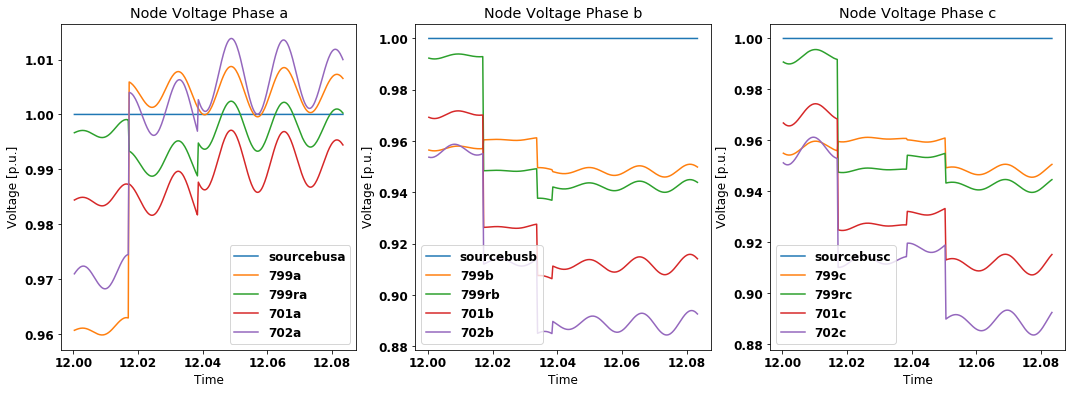

<Figure size 1296x432 with 0 Axes>

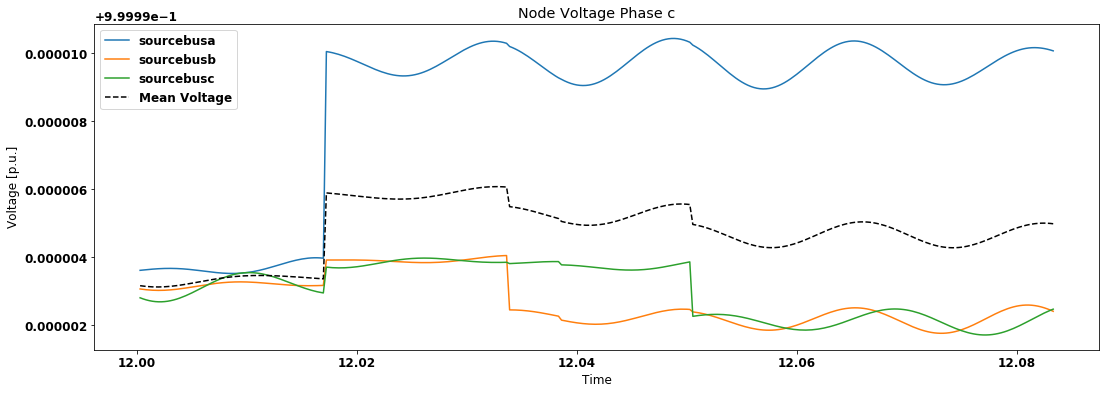

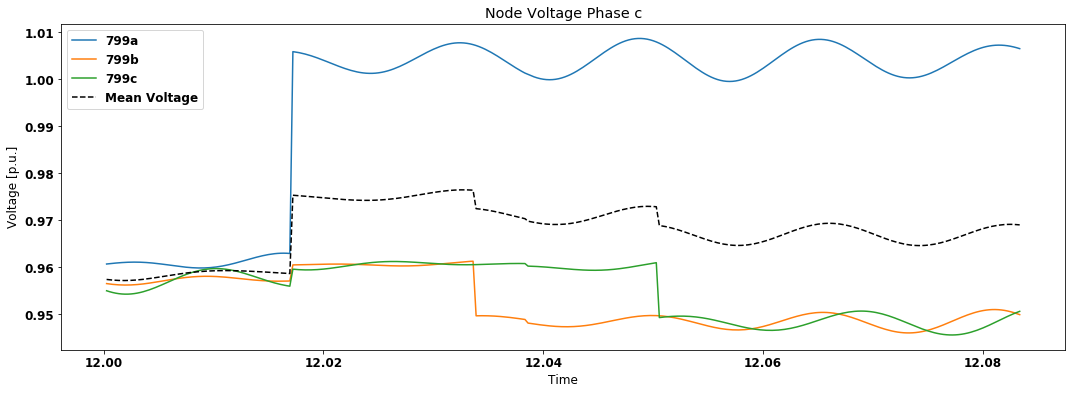

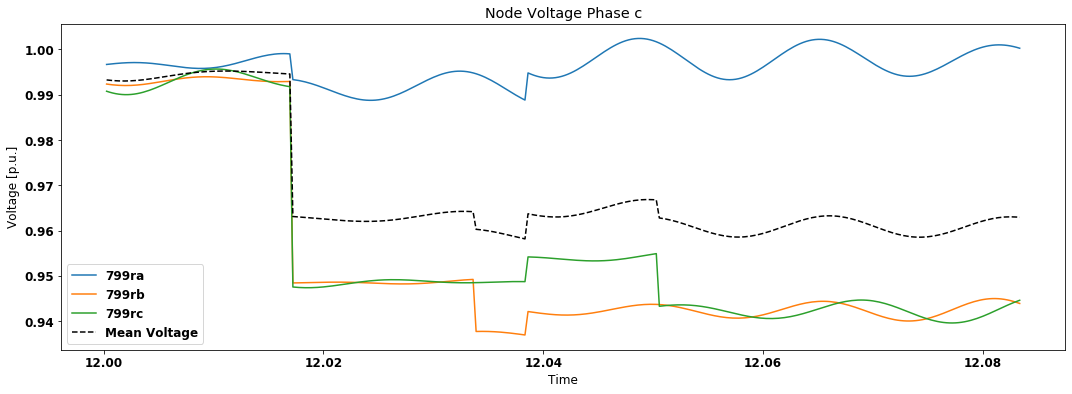

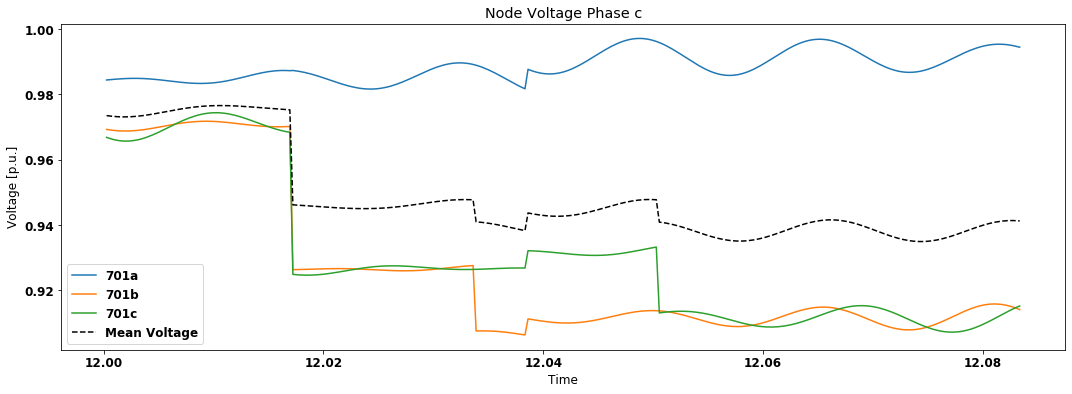

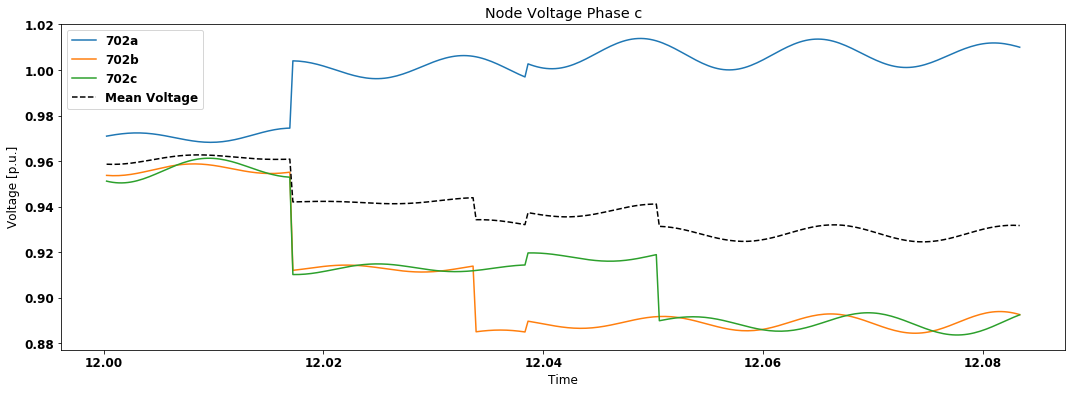

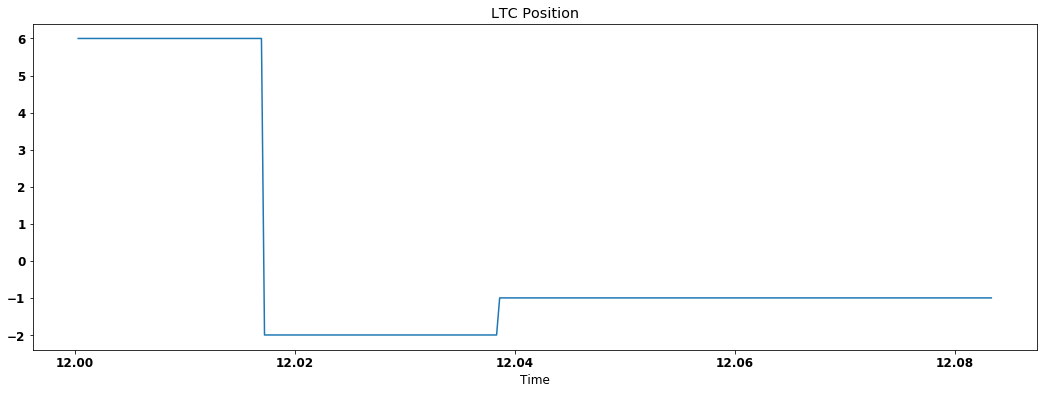

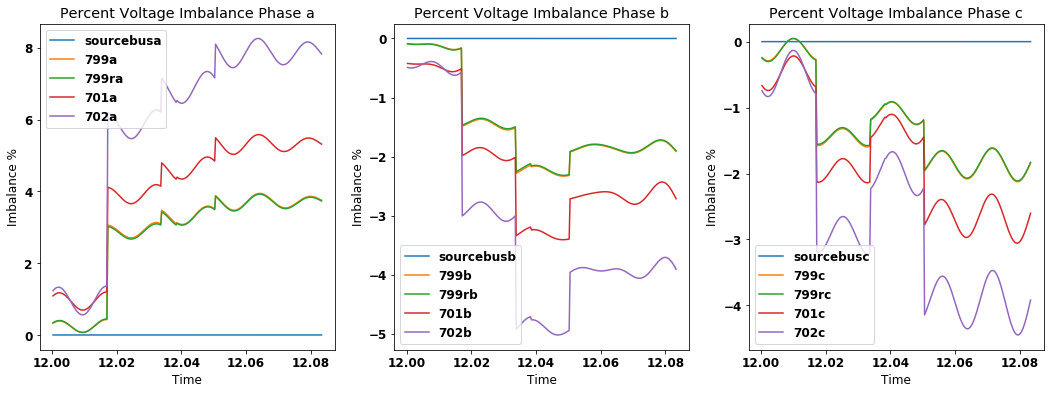

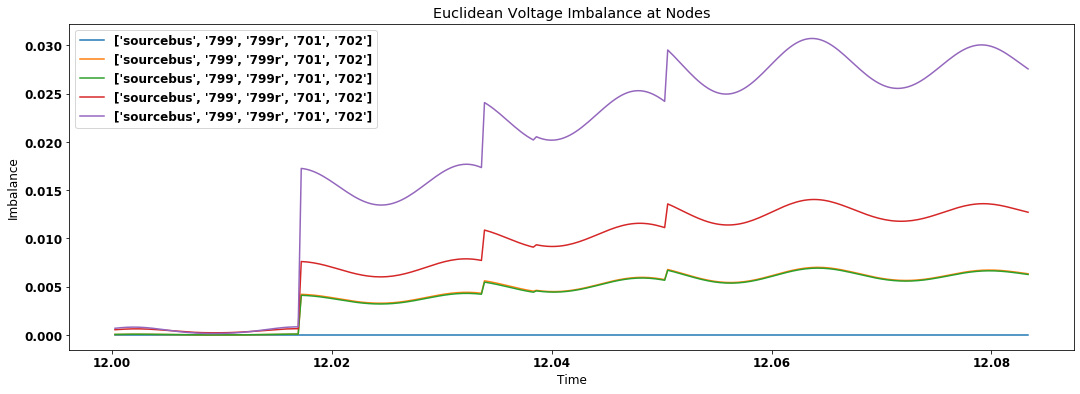

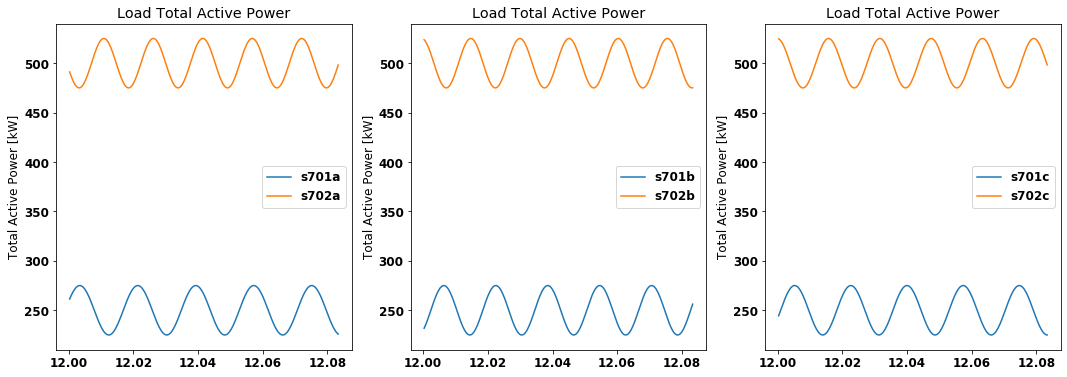

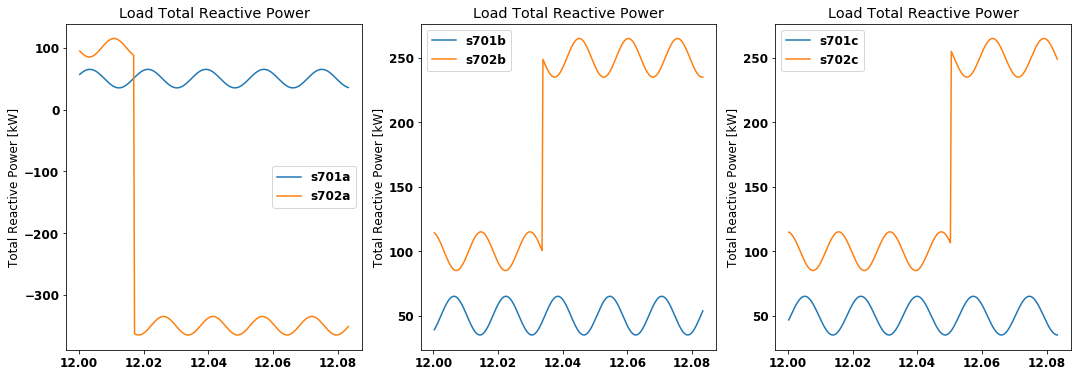

In [8]:
font = {'weight':'bold', 'size':12}

plt.rc('font', **font)

plotStartTimeStep = 12*3600 + 1
plotEndTimeStep = 12*3600 + 1 + 300

time = np.arange(plotStartTimeStep,plotEndTimeStep)

timehh = ((time-1)/3600).astype(int)
timemm = ((time-1) - 3600*timehh)/60

timeplot = timehh.astype(float) + timemm/100

# fig = plt.figure(figsize=[12,6])
# # for k1 in range(0,LoadBusVoltage.shape[1]):
# for k1 in range(len(LoadBuses)):
# #     plt.plot(time/3600,LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1])
#     plt.plot(timeplot,LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1] - np.mean(LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1]))
# #     print(LoadBuses[k1])
# plt.title('Node Voltage')
# plt.xlabel('Time')
# plt.ylabel('Voltage [p.u.]')
# plt.show()

phlist = ['a','b','c']


fig = plt.figure(figsize=[18,6])
for phnum in range(0,3):
    plt.subplot(1,3,phnum+1)
    for k1 in range(len(AllBuses)):        
        plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
    plt.legend()
    plt.title('Node Voltage Phase ' + phlist[phnum])
    plt.xlabel('Time')
    plt.ylabel('Voltage [p.u.]')
plt.show()

fig = plt.figure(figsize=[18,6])
for k1 in range(len(AllBuses)):
    fig = plt.figure(figsize=[18,6])
#     plt.subplot(1,len(AllBuses),k1)
    for phnum in range(0,3):
        plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
    plt.plot(time/3600,np.mean(AllBusVoltage[plotStartTimeStep:plotEndTimeStep,:,k1],axis=1),'k--',label='Mean Voltage')
    plt.legend()
    plt.title('Node Voltage Phase ' + phlist[phnum])
    plt.xlabel('Time')
    plt.ylabel('Voltage [p.u.]')
plt.show()

fig = plt.figure(figsize=[18,6])
plt.plot(time/3600,TapPos[plotStartTimeStep:plotEndTimeStep])
# plt.legend()
plt.title('LTC Position')
plt.xlabel('Time')
plt.show()

fig = plt.figure(figsize=[18,6])
for phnum in range(0,3):
    plt.subplot(1,3,phnum+1)
    for k1 in range(len(AllBuses)):        
        plt.plot(time/3600,100*Voltage_Imbalance_01[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
    plt.legend()
    plt.title('Percent Voltage Imbalance Phase ' + phlist[phnum])
    plt.xlabel('Time')
    plt.ylabel('Imbalance %')
plt.show()

fig = plt.figure(figsize=[18,6])
plt.plot(time/3600,Voltage_Imbalance_02[plotStartTimeStep:plotEndTimeStep],label=AllBuses)
plt.title('Euclidean Voltage Imbalance at Nodes')
plt.xlabel('Time')
plt.ylabel('Imbalance')
plt.legend()
plt.show()

# fig = plt.figure(figsize=[18,6])
# # for k1 in range(0,LoadBusVoltage.shape[1]):
# for k1 in range(len(AllBuses)):
#     for phnum in range(0,3):
#         plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
# #     print(LoadBuses[k1])
# plt.title('Node Voltage')
# plt.xlabel('Time')
# plt.ylabel('Voltage [p.u.]')
# plt.legend()
# plt.show()

# fig = plt.figure(figsize=[12,6])
# for k1 in range(0,len(inverters)):
# #     plt.plot(inverters[k1].Vmeas[plotStartTimeStep:plotEndTimeStep])
#     plt.plot(time/3600,inverters[k1].Vlp[plotStartTimeStep:plotEndTimeStep])
# # plt.ylim([0.85, 1.05])
# plt.title('Inverter Low-pass Filter Voltage')
# plt.xlabel('Time')
# plt.ylabel('Voltage [p.u.]')
# plt.show()

# fig = plt.figure(figsize=[12,6])
# for k1 in range(0,len(inverters)):
#     plt.plot(time/3600,inverters[k1].reactive_power[plotStartTimeStep:plotEndTimeStep])
# # plt.ylim([-100, 100])
# plt.title('Inverter Reactive Power Output')
# plt.xlabel('Time')
# plt.ylabel('Percent Capacity [%]')
# plt.show()

# # fig = plt.figure(figsize=[12,6])
# # plt.plot(time/3600,PloadTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.plot(time/3600,QloadTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.title('Load Demands')
# # plt.xlabel('Time')
# # plt.ylabel('Percent Capacity [%]')
# # plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.subplot(2,1,1)
# plt.plot(time/3600,PloadTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Active Power Demand')
# # plt.xlabel('Time')
# plt.ylabel('Active Power Demand [kW]')
# plt.subplot(2,1,2)
# plt.plot(time/3600,QloadTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Reactive Power Demand')
# plt.xlabel('Time')
# plt.ylabel('Reactive Power Demand [kVAr]')
# plt.show()

# # fig = plt.figure(figsize=[12,6])
# # plt.plot(time/3600,PinjTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.plot(time/3600,QinjTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.title('Injection')
# # plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.subplot(2,1,1)
# plt.plot(time/3600,PinjTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Active Power Injection')
# # plt.xlabel('Time')
# plt.ylabel('Active Power Injection [kW]')
# plt.subplot(2,1,2)
# plt.plot(time/3600,QinjTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Reactive Power Injection')
# plt.xlabel('Time')
# plt.ylabel('Reactive Power Injection [kVAr]')
# plt.show()

# # fig = plt.figure(figsize=[12,6])
# # plt.plot(time/3600,PtotalTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.plot(time/3600,QtotalTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.title('Total')
# # plt.show()

fig = plt.figure(figsize=[18,6])
for phnum in range(0,3):
    plt.subplot(1,3,phnum+1)
    for k1 in range(len(LoadBuses)):
        if LoadBuses[k1][-1] == phlist[phnum]:
            plt.plot(time/3600,PtotalTS[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=LoadBuses[k1])
    plt.title('Load Total Active Power')
    # plt.xlabel('Time')
    plt.ylabel('Total Active Power [kW]')
    plt.legend()
plt.show()

fig = plt.figure(figsize=[18,6])
for phnum in range(0,3):
    plt.subplot(1,3,phnum+1)
    for k1 in range(len(LoadBuses)):
        if LoadBuses[k1][-1] == phlist[phnum]:
            plt.plot(time/3600,QtotalTS[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=LoadBuses[k1])
    plt.title('Load Total Reactive Power')
    # plt.xlabel('Time')
    plt.ylabel('Total Reactive Power [kW]')
    plt.legend()
plt.show()



In [9]:
LoadBuses[k1][-1] == 'b'

False

In [10]:
for k1 in range(len(AllBuses)):
    print(AllBuses[k1])
    dss.Circuit.SetActiveBus(AllBuses[k1])
    print(dss.Bus.Name())
    print(dss.Bus.Nodes())
    

sourcebus
sourcebus
[1, 2, 3]
799
799
[1, 2, 3]
799r
799r
[1, 2, 3]
701
701
[1, 2, 3]
702
702
[1, 2, 3]


In [11]:
dss.Circuit.AllNodeNamesByPhase(3)

['sourcebus.3', '799.3', '799r.3', '701.3', '702.3']

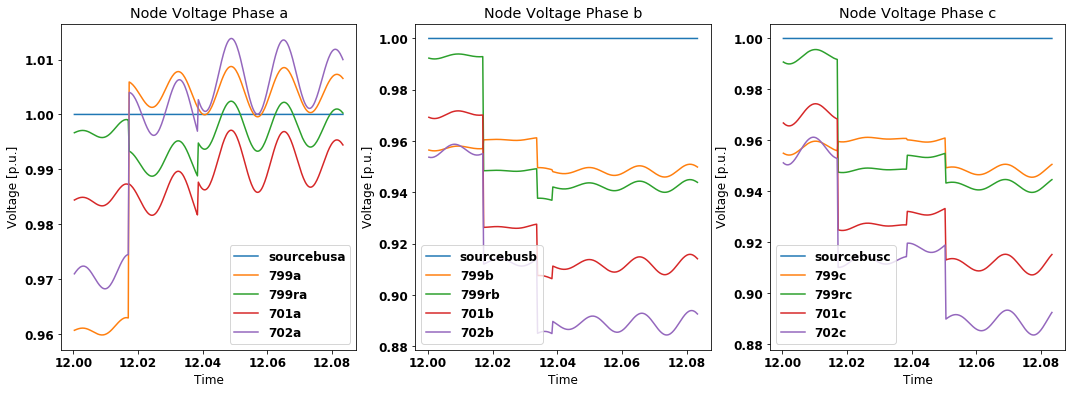

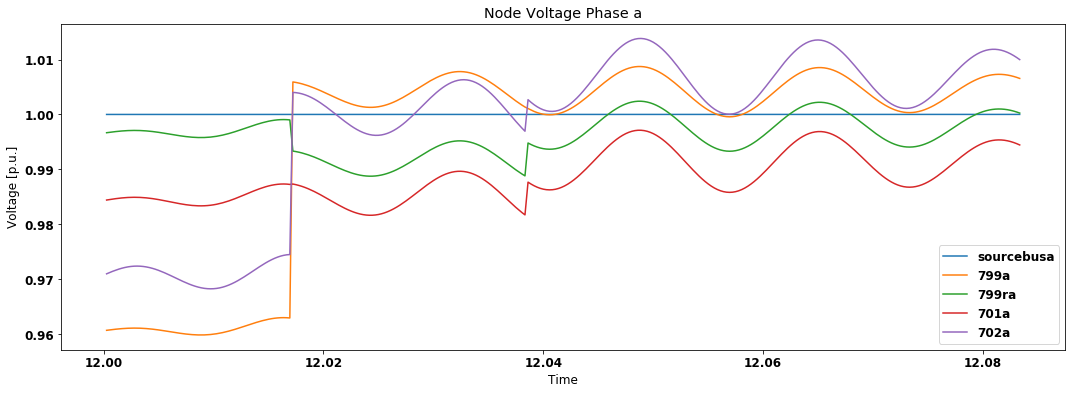

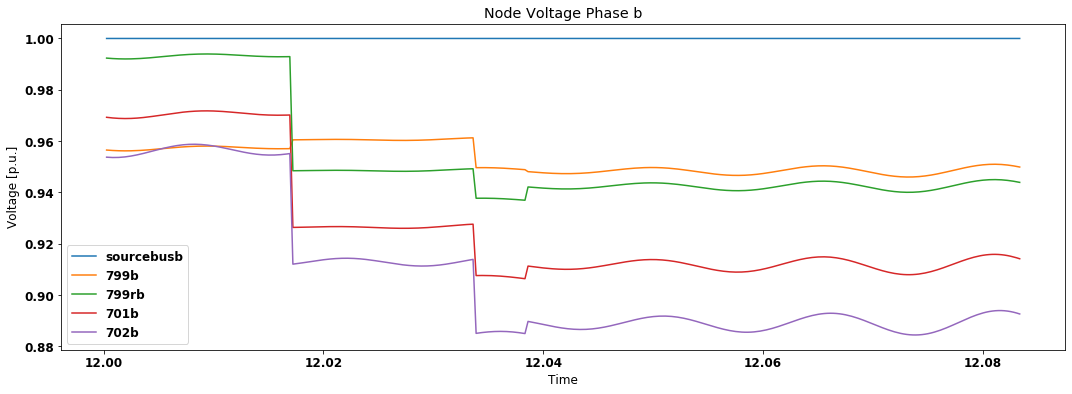

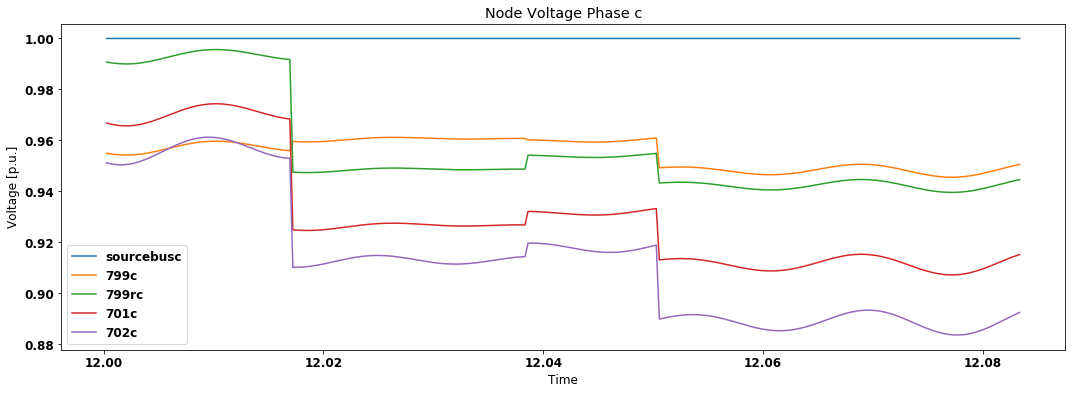

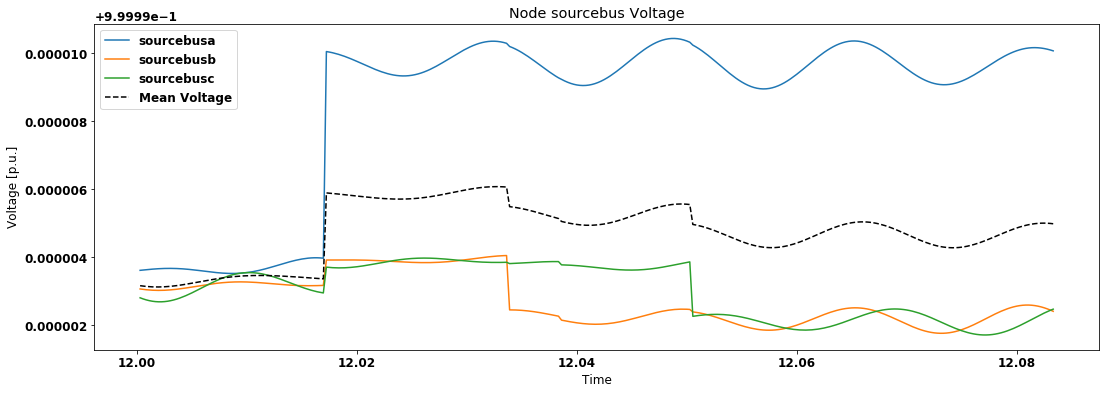

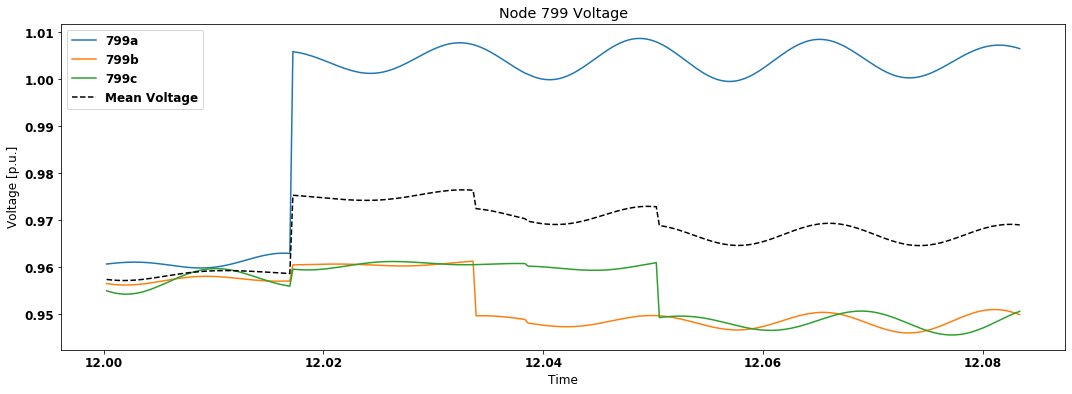

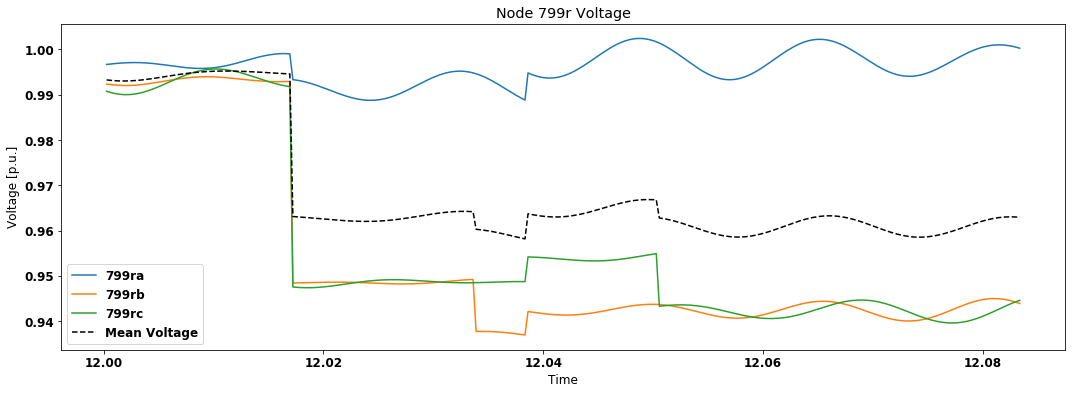

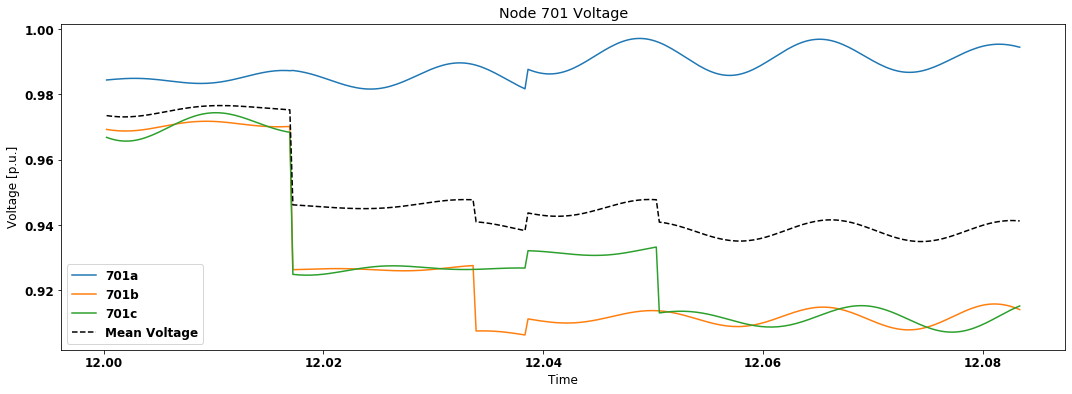

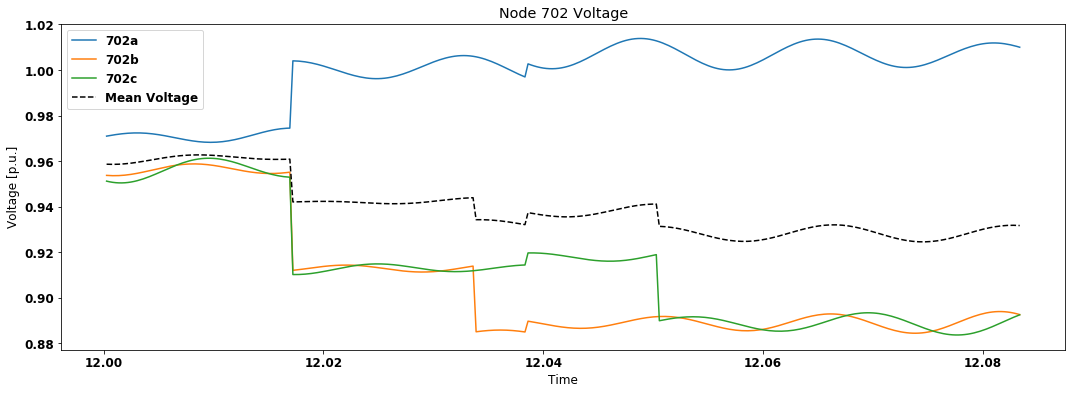

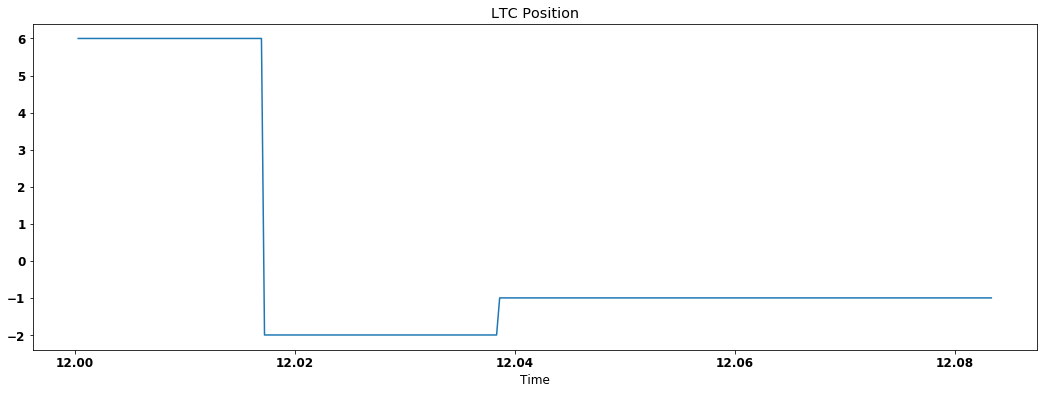

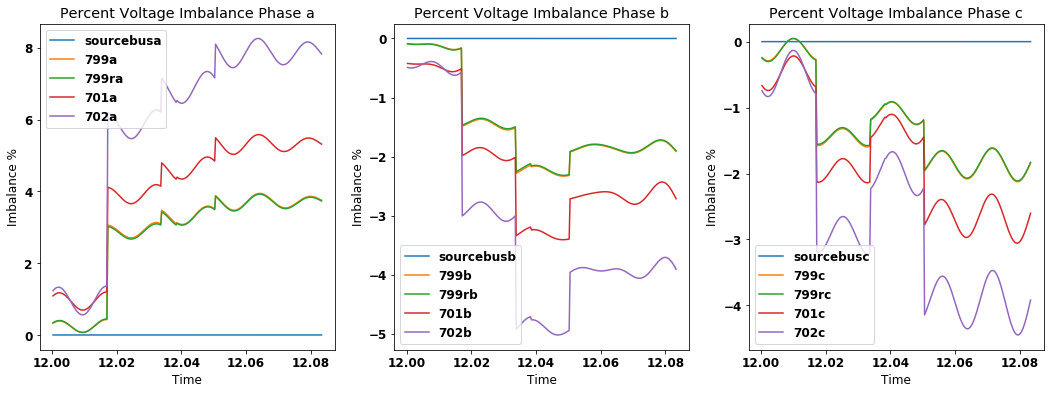

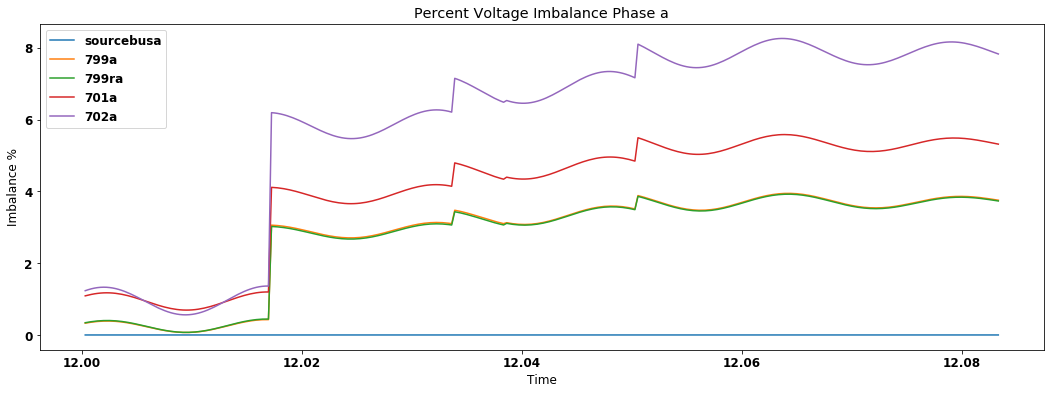

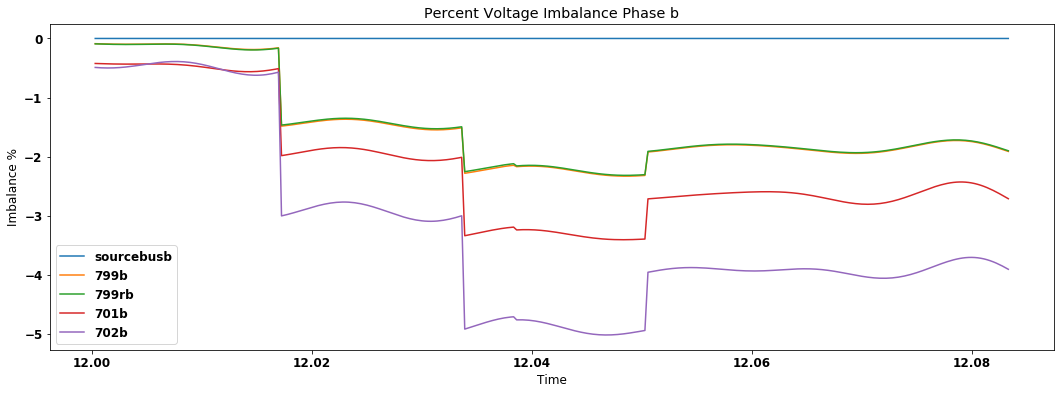

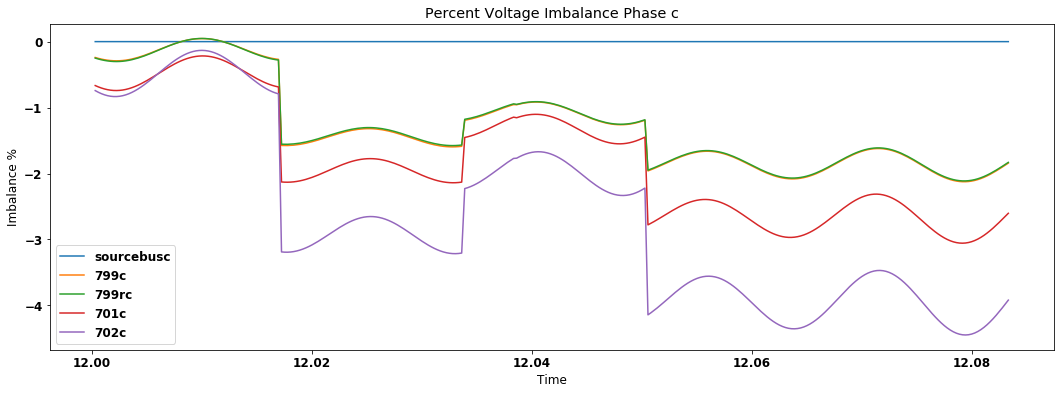

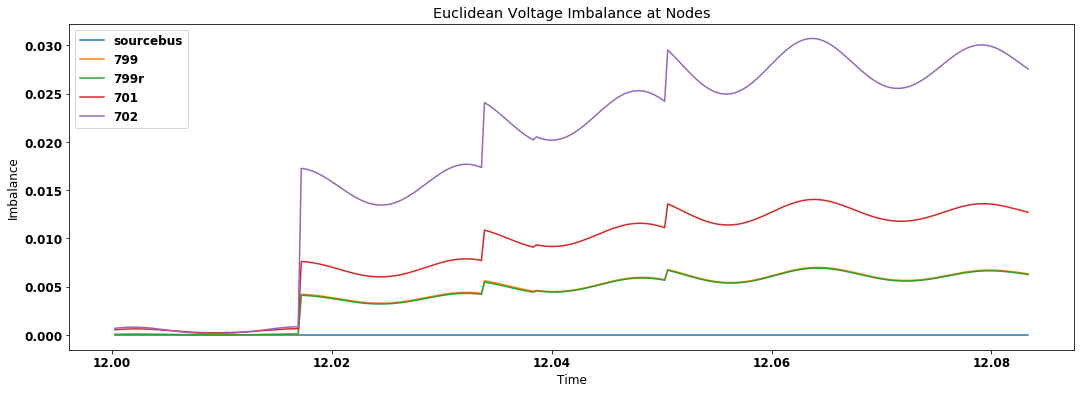

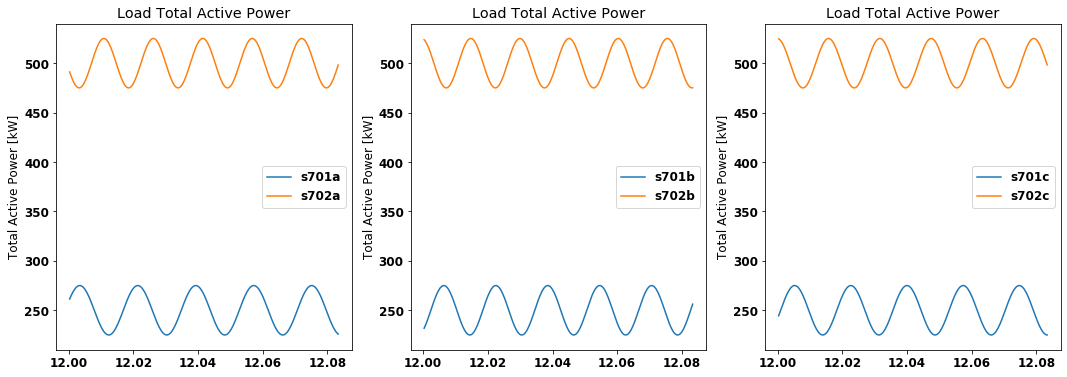

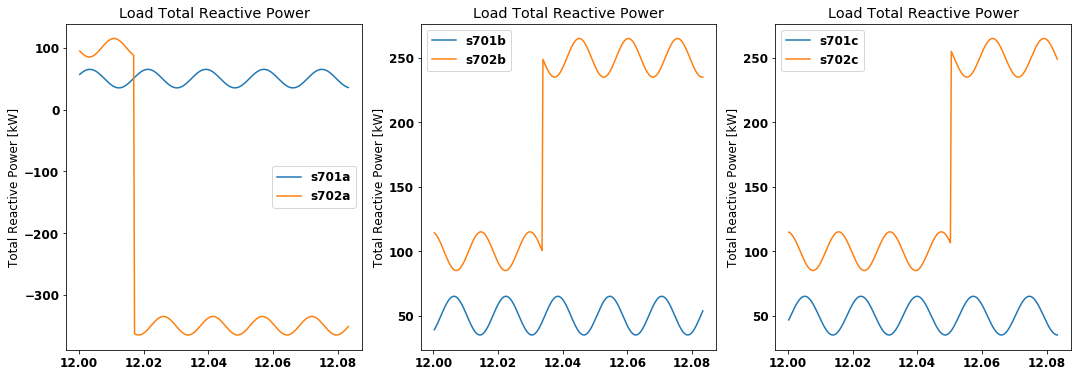

In [12]:
font = {'weight':'bold', 'size':12}

plt.rc('font', **font)

plotStartTimeStep = 12*3600 + 1
plotEndTimeStep = 12*3600 + 1 + 300

time = np.arange(plotStartTimeStep,plotEndTimeStep)

timehh = ((time-1)/3600).astype(int)
timemm = ((time-1) - 3600*timehh)/60

timeplot = timehh.astype(float) + timemm/100

# fig = plt.figure(figsize=[12,6])
# # for k1 in range(0,LoadBusVoltage.shape[1]):
# for k1 in range(len(LoadBuses)):
# #     plt.plot(time/3600,LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1])
#     plt.plot(timeplot,LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1] - np.mean(LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1]))
# #     print(LoadBuses[k1])
# plt.title('Node Voltage')
# plt.xlabel('Time')
# plt.ylabel('Voltage [p.u.]')
# plt.show()

phlist = ['a','b','c']


fig = plt.figure(figsize=[18,6])
for phnum in range(0,3):
    plt.subplot(1,3,phnum+1)
    for k1 in range(len(AllBuses)):        
        plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
    plt.legend()
    plt.title('Node Voltage Phase ' + phlist[phnum])
    plt.xlabel('Time')
    plt.ylabel('Voltage [p.u.]')
plt.show()


# fig = plt.figure(figsize=[18,6])
for phnum in range(0,3):
    fig = plt.figure(figsize=[18,6])
    for k1 in range(len(AllBuses)):        
        plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
    plt.legend()
    plt.title('Node Voltage Phase ' + phlist[phnum])
    plt.xlabel('Time')
    plt.ylabel('Voltage [p.u.]')
    plt.show()
    fig.savefig('/home/michael/Desktop/temp/Phase_'+phlist[phnum]+'_voltage.png',bbox_inches='tight')

# fig = plt.figure(figsize=[18,6])
for k1 in range(len(AllBuses)):
    fig = plt.figure(figsize=[18,6])
#     plt.subplot(1,len(AllBuses),k1)
    for phnum in range(0,3):
        plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
    plt.plot(time/3600,np.mean(AllBusVoltage[plotStartTimeStep:plotEndTimeStep,:,k1],axis=1),'k--',label='Mean Voltage')
    plt.legend()
    plt.title('Node ' + AllBuses[k1] + ' Voltage')
    plt.xlabel('Time')
    plt.ylabel('Voltage [p.u.]')
    plt.show()
    fig.savefig('/home/michael/Desktop/temp/Node_'+AllBuses[k1]+'_voltage.png',bbox_inches='tight')

fig = plt.figure(figsize=[18,6])
plt.plot(time/3600,TapPos[plotStartTimeStep:plotEndTimeStep])
# plt.legend()
plt.title('LTC Position')
plt.xlabel('Time')
plt.show()
fig.savefig('/home/michael/Desktop/temp/LTC_position.png',bbox_inches='tight')

fig = plt.figure(figsize=[18,6])
for phnum in range(0,3):
    plt.subplot(1,3,phnum+1)
    for k1 in range(len(AllBuses)):        
        plt.plot(time/3600,100*Voltage_Imbalance_01[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
    plt.legend()
    plt.title('Percent Voltage Imbalance Phase ' + phlist[phnum])
    plt.xlabel('Time')
    plt.ylabel('Imbalance %')
plt.show()

# fig = plt.figure(figsize=[18,6])
for phnum in range(0,3):
    fig = plt.figure(figsize=[18,6])
    for k1 in range(len(AllBuses)):        
        plt.plot(time/3600,100*Voltage_Imbalance_01[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
    plt.legend()
    plt.title('Percent Voltage Imbalance Phase ' + phlist[phnum])
    plt.xlabel('Time')
    plt.ylabel('Imbalance %')
    plt.show()
    fig.savefig('/home/michael/Desktop/temp/Phase_'+phlist[phnum]+'_imbalance.png',bbox_inches='tight')

fig = plt.figure(figsize=[18,6])
for k1 in range(len(AllBuses)):
    plt.plot(time/3600,Voltage_Imbalance_02[plotStartTimeStep:plotEndTimeStep,k1],label=AllBuses[k1])
plt.title('Euclidean Voltage Imbalance at Nodes')
plt.xlabel('Time')
plt.ylabel('Imbalance')
plt.legend()
plt.show()
fig.savefig('/home/michael/Desktop/temp/Node_imbalance.png',bbox_inches='tight')

# fig = plt.figure(figsize=[18,6])
# # for k1 in range(0,LoadBusVoltage.shape[1]):
# for k1 in range(len(AllBuses)):
#     for phnum in range(0,3):
#         plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
# #     print(LoadBuses[k1])
# plt.title('Node Voltage')
# plt.xlabel('Time')
# plt.ylabel('Voltage [p.u.]')
# plt.legend()
# plt.show()

# fig = plt.figure(figsize=[12,6])
# for k1 in range(0,len(inverters)):
# #     plt.plot(inverters[k1].Vmeas[plotStartTimeStep:plotEndTimeStep])
#     plt.plot(time/3600,inverters[k1].Vlp[plotStartTimeStep:plotEndTimeStep])
# # plt.ylim([0.85, 1.05])
# plt.title('Inverter Low-pass Filter Voltage')
# plt.xlabel('Time')
# plt.ylabel('Voltage [p.u.]')
# plt.show()

# fig = plt.figure(figsize=[12,6])
# for k1 in range(0,len(inverters)):
#     plt.plot(time/3600,inverters[k1].reactive_power[plotStartTimeStep:plotEndTimeStep])
# # plt.ylim([-100, 100])
# plt.title('Inverter Reactive Power Output')
# plt.xlabel('Time')
# plt.ylabel('Percent Capacity [%]')
# plt.show()

# # fig = plt.figure(figsize=[12,6])
# # plt.plot(time/3600,PloadTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.plot(time/3600,QloadTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.title('Load Demands')
# # plt.xlabel('Time')
# # plt.ylabel('Percent Capacity [%]')
# # plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.subplot(2,1,1)
# plt.plot(time/3600,PloadTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Active Power Demand')
# # plt.xlabel('Time')
# plt.ylabel('Active Power Demand [kW]')
# plt.subplot(2,1,2)
# plt.plot(time/3600,QloadTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Reactive Power Demand')
# plt.xlabel('Time')
# plt.ylabel('Reactive Power Demand [kVAr]')
# plt.show()

# # fig = plt.figure(figsize=[12,6])
# # plt.plot(time/3600,PinjTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.plot(time/3600,QinjTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.title('Injection')
# # plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.subplot(2,1,1)
# plt.plot(time/3600,PinjTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Active Power Injection')
# # plt.xlabel('Time')
# plt.ylabel('Active Power Injection [kW]')
# plt.subplot(2,1,2)
# plt.plot(time/3600,QinjTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Reactive Power Injection')
# plt.xlabel('Time')
# plt.ylabel('Reactive Power Injection [kVAr]')
# plt.show()

# # fig = plt.figure(figsize=[12,6])
# # plt.plot(time/3600,PtotalTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.plot(time/3600,QtotalTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.title('Total')
# # plt.show()

fig = plt.figure(figsize=[18,6])
for phnum in range(0,3):
    plt.subplot(1,3,phnum+1)
    for k1 in range(len(LoadBuses)):
        if LoadBuses[k1][-1] == phlist[phnum]:
            plt.plot(time/3600,PtotalTS[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=LoadBuses[k1])
    plt.title('Load Total Active Power')
    # plt.xlabel('Time')
    plt.ylabel('Total Active Power [kW]')
    plt.legend()
plt.show()

fig = plt.figure(figsize=[18,6])
for phnum in range(0,3):
    plt.subplot(1,3,phnum+1)
    for k1 in range(len(LoadBuses)):
        if LoadBuses[k1][-1] == phlist[phnum]:
            plt.plot(time/3600,QtotalTS[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=LoadBuses[k1])
    plt.title('Load Total Reactive Power')
    # plt.xlabel('Time')
    plt.ylabel('Total Reactive Power [kW]')
    plt.legend()
plt.show()



In [13]:
inverters[0].nodename

's702a'

In [14]:
dss.Text.Command("new load.load_670_a_01 phases=1 bus1=702.1 conn=wye kV=4.16 kW=5400 kvar=200 model=1")

In [15]:
for k1 in range(len(dss.Loads.AllNames())):
    print(dss.Loads.AllNames()[k1])
    dss.Loads.Name(dss.Loads.AllNames()[k1])
    print(dss.CktElement.BusNames()[0])
    print(str.split(dss.CktElement.BusNames()[0],'.'))
    print(str.split(dss.CktElement.BusNames()[0],'.')[0])
    print('~')

s701a
701.1
['701', '1']
701
~
s701b
701.2
['701', '2']
701
~
s701c
701.3
['701', '3']
701
~
s702a
702.1
['702', '1']
702
~
s702b
702.2
['702', '2']
702
~
s702c
702.3
['702', '3']
702
~
load_670_a_01
702.1
['702', '1']
702
~


In [16]:
for k1 in range(len(dss.Loads.AllNames())):
    print(dss.Loads.AllNames()[k1])
    dss.Loads.Name(dss.Loads.AllNames()[k1])
    print(dss.CktElement.BusNames()[0])
    print(str.split(dss.CktElement.BusNames()[0],'.'))
    dss.Circuit.SetActiveBus(dss.CktElement.BusNames()[0])
    print(dss.Bus.puVmagAngle()[::2])
    print('~~')

s701a
701.1
['701', '1']
[0.9886343258611022, 0.9050428985946777, 0.9161906421295873]
~~
s701b
701.2
['701', '2']
[0.9886343258611022, 0.9050428985946777, 0.9161906421295873]
~~
s701c
701.3
['701', '3']
[0.9886343258611022, 0.9050428985946777, 0.9161906421295873]
~~
s702a
702.1
['702', '1']
[1.003779297310166, 0.8812411340131485, 0.8946066661131538]
~~
s702b
702.2
['702', '2']
[1.003779297310166, 0.8812411340131485, 0.8946066661131538]
~~
s702c
702.3
['702', '3']
[1.003779297310166, 0.8812411340131485, 0.8946066661131538]
~~
load_670_a_01
702.1
['702', '1']
[1.003779297310166, 0.8812411340131485, 0.8946066661131538]
~~


In [17]:
for k1 in range(len(dss.Circuit.AllBusNames())):
    dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
    print(dss.Bus.Name())
    print(dss.Bus.Nodes())
    print(dss.Bus.puVmagAngle()[::2])
    print('~~~')

sourcebus
[1, 2, 3]
[0.9999993598020498, 0.9999914876255747, 0.9999925353275763]
~~~
799
[1, 2, 3]
[1.0018586534172023, 0.9441732322737492, 0.9511789086455585]
~~~
799r
[1, 2, 3]
[0.9955756978618314, 0.9382274592784697, 0.945194067712266]
~~~
701
[1, 2, 3]
[0.9886343258611022, 0.9050428985946777, 0.9161906421295873]
~~~
702
[1, 2, 3]
[1.003779297310166, 0.8812411340131485, 0.8946066661131538]
~~~


In [18]:
# for k1 in range(len(dss.Circuit.AllBusNames())):
#     dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
#     print(dss.Bus.Name())
#     print(dss.CktElement.Powers())
    

In [19]:
# for k1 in range(len(dss.Loads.AllNames())):
#     print(dss.Loads.AllNames()[k1])
#     dss.Loads.Name(dss.Loads.AllNames()[k1])
#     print(dss.CktElement.Powers())

In [20]:

class inverter():
    
    def __init__(self):
        
        self.max_reactive_capacity = 1
        self.reactive_capacity = 1
    
        self.reactive_power = 0
    
        self.VBP = np.array([0.97, 0.99, 1.01, 1.03])
        
        self.wlp = 2*np.pi*0.10
        
        self.Vmeas = np.zeros(86401)
        self.Vlp = np.zeros(86401)
        
        self.reactive_power = np.zeros(86401)
        
        self.Ts = 1
        
        self.hackFlag = False
        
        self.pset = 0
        self.pout = 0
        
        self.qset = 0
        self.qout = 0
        
    def set_timesteps(self, startTimeStep, endTimeStep):
        self.startTimeStep = startTimeStep
        self.endTimeStep = endTimeStep
        
    def set_nodenum(self, nodenum):
        self.nodenum = nodenum
        
    def set_nodename(self, nodename):
        self.nodename = nodename
        
    def set_phase(self, phase):
        self.phase = phase
        
    def set_loadname(self, loadname):
        self.loadname = loadname
            
    def set_VBP(self, VBP):
        self.VBP = VBP
        
    def measure_voltage(self, timeStep, Vmeas):
        self.Vmeas[kt] = Vmeas
        
    def lowpass(self, kt):
        self.Vlp[kt] = (1 - self.wlp*self.Ts)*self.Vlp[kt-1] + self.wlp*self.Ts*self.Vmeas[kt-1]
        
    def compute_reactive_power_output(self, kt, Vcomp):
        if Vcomp <= self.VBP[0]:
            self.reactive_power[kt] = -100
        elif self.VBP[0] <= Vcomp <= self.VBP[1]:
            self.reactive_power[kt] =100/(self.VBP[1] - self.VBP[0])*(Vcomp - self.VBP[1])
        elif self.VBP[1] <= Vcomp <= self.VBP[2]:
            self.reactive_power[kt] = 0
        elif self.VBP[2] <= Vcomp <= self.VBP[3]:
            self.reactive_power[kt] = 100/(self.VBP[3] - self.VBP[2])*(Vcomp - self.VBP[2])
        elif self.VBP[3] <= Vcomp:
            self.reactive_power[kt] = 100
        # print(self.reactive_power)
        
    def set_active_power_setpoint(self, pset):
        self.pset = pset
        self.pout = self.pset
        
    def set_reactive_power_setpoint(self, qset):
        self.qset = qset
        self.qout = self.qset
        
    

x1 = inverter()
x1.set_VBP(np.array([0.97, 0.99, 1.01, 1.03]))
print(x1.VBP)

x1.compute_reactive_power_output(0,1.02)
print(x1.reactive_power)

# x1.measure_voltage(0,1.02)
# x1.measure_voltage(1,1.02)
# x1.measure_voltage(2,1.02)
# x1.measure_voltage(3,1.01)
# x1.measure_voltage(4,1.01)
# x1.measure_voltage(5,1.01)


print(x1.Vmeas)
print(x1.Vlp)

[0.97 0.99 1.01 1.03]
[50.  0.  0. ...  0.  0.  0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [21]:
#########################################################
################### RESTART OPENDSS #####################
#########################################################
dss.run_command('Redirect feeder/03node_multiphase_balanced.dss')
dss.Solution.Solve()


if dss.Solution.Converged:
    print('Initial Model Converged. Proceeding to Next Step.')
    
else:
    print('Initial Solution Not Converged. Check Model for Convergence')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')
    
for k1 in range(len(dss.RegControls.AllNames())):
    print(dss.RegControls.AllNames()[k1])
    dss.RegControls.Name(dss.RegControls.AllNames()[k1])
    
    print(dss.RegControls.TapNumber())

############################################
############ INIT NODES ####################
############################################
""" 
 nodes' variable is a dictionary contains all the nodes in the grid,
 with KEY is the node's number, VALUE is a dataframe with 
 ROW is ['Voltage', 'Generation', 'P', 'Q'] - Voltage is Voltage for each timestep; 
                                              P,Q is P,Q injection at that node for that timestep.
 and 
 COLUMN is each timestep for the whole simulation. 
 nodes = {
    1: dataFrame1,
    2: dataFrame2
 }
"""

nodes = {}
features = ['Voltage', 'Generation', 'P', 'Q']

# for k1 in range(len(AllLoadNames)):
#     print(k1)
#     df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
#     nodes[k1] = df
#     nodes[k1].loc['Generation'] = Generation[:,k1]
#     nodes[k1].loc['Load'] = Load[:,k1]
#     nodes[k1].loc['P'] = 0
#     nodes[k1].loc['Q'] = 0
#     nodes[k1].loc['Pinj'] = 0
#     nodes[k1].loc['Qinj'] = 0

simStartTimeStep = 12*3600+1
simEndTimeStep = 12*3600+1 + 3600

simStartTimeStep = 6*3600+1
simEndTimeStep = 18*3600+1

simStartTimeStep = 12*3600+1
simEndTimeStep = 12*3600+1 + 1200

simStartTimeStep = 12*3600+1 - 300
simEndTimeStep = 12*3600+1 + 600

time = np.arange(simStartTimeStep,simEndTimeStep)

totalSimTimeSteps = simEndTimeStep - simStartTimeStep + 1

AllLoads = dss.Loads.AllNames()
AllBuses = dss.Circuit.AllBusNames()

phlist = ['a', 'b', 'c', 'ab', 'bc', 'ca']

##################################################
# Set up inverter OpenDSS loads
##################################################

for k1 in range(len(AllBuses)):
    if AllBuses[k1] != 'sourcebus' or AllBuses[k1] != '799' or AllBuses[k1] != '799r':
        print(AllBuses[k1])
        dss.Circuit.SetActiveBus(AllBuses[k1])
        for k2 in range(len(dss.Bus.Nodes())):
            print(dss.Bus.Nodes()[k2])
            namestr = 'new load.inverter_' + AllBuses[k1] + '_' + phlist[dss.Bus.Nodes()[k2]-1]
            phstr = 'phases=1'
            busstr = 'bus1=' + AllBuses[k1] + '.' + str(dss.Bus.Nodes()[k2])
            connstr = 'conn=wye'
            kVstr = 'kV=' + str(dss.Bus.kVBase())
            loadstr = 'kW=0 kvar=0 model=1'

            commstr = namestr + ' ' + phstr + ' ' + busstr + ' ' + connstr + ' ' + kVstr + ' ' + loadstr
            print(commstr)

            dss.Text.Command(commstr)
        
AllLoads = dss.Loads.AllNames()
AllBuses = dss.Circuit.AllBusNames()

##################################################
# Set up loads
##################################################

Nload = 25
Load_factored = Load/1.25

load_indexes = np.zeros((len(AllBuses), Nload)).astype(int)
for k1 in range(len(AllBuses)):
    
    load_indexes[k1,:] = np.random.randint(0, Load.shape[1], size=Nload).astype(int)
#     load_indexes[k1,:] = load_indexes[k1,:].astype(int)
#     print(load_indexes[k1,:])

# print(load_indexes)
# print(Load_factored[load_indexes[0,:],0])


##################################################
# Set up generation
##################################################

Ngen = 15
Generation_factored = Generation/1.5

generation_indexes = np.zeros((len(AllBuses), Ngen)).astype(int)
for k1 in range(len(AllBuses)):
    
    generation_indexes[k1,:] = np.random.randint(0, Load.shape[1], size=Ngen).astype(int)
#     generation_indexes[k1,:] = generation_indexes[k1,:].astype(int)
#     print(generation_indexes[k1,:])

# print(generation_indexes)
# print(Generation_factored[generation_indexes[0,:],0])


##################################################
# Set up inverters
##################################################


print(dss.Loads.AllNames()[k1])
dss.Loads.Name(dss.Loads.AllNames()[k1])
print(dss.CktElement.BusNames()[0])
print(str.split(dss.CktElement.BusNames()[0],'.'))
dss.Circuit.SetActiveBus(dss.CktElement.BusNames()[0])
print(dss.Bus.puVmagAngle()[::2])
print('~~')
       
inverters = []
for k1 in range(len(AllLoads)):
    if AllLoads[k1] == 'inverter_702_a' or AllLoads[k1] == 'inverter_702_b' or AllLoads[k1] == 'inverter_702_c':
#         for k2 in range(generation_indexes.shape[1]):
        for k2 in range(0,1):
        
            dss.Loads.Name(dss.Loads.AllNames()[k1])
            
            tempnodename = str.split(dss.CktElement.BusNames()[0],'.')[0]
            tempphase = phlist[int(str.split(dss.CktElement.BusNames()[0],'.')[1])-1]
            
            print(tempnodename)
            print(tempphase)
            
            tempinverter = inverter()
            tempinverter.set_timesteps(simStartTimeStep, simEndTimeStep)
#             tempinverter.set_nodenum(k1)
            tempinverter.set_nodename(tempnodename)
        
            tempinverter.set_phase(tempphase)
            
            tempinverter.set_loadname(AllLoads[k1])
    
    
            tempinverter.set_VBP(np.array([0.95, 0.97, 1.03, 1.05]))
            tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))

            inverters.append(tempinverter)

    
##################################################
# ?
##################################################

AllLoads = dss.Loads.AllNames()
AllBuses = dss.Circuit.AllBusNames()

LoadBusVoltage = np.zeros((TotalTimeSteps,3,len(AllLoads)))
AllBusVoltage = np.zeros((TotalTimeSteps,3,len(AllBuses)))

LoadBusPinj = np.zeros((TotalTimeSteps,3,len(AllLoads))) 
LoadBusQinj = np.zeros((TotalTimeSteps,3,len(AllLoads)))

kWloadTS = np.zeros((TotalTimeSteps,3,len(AllLoads)))
kVArloadTS = np.zeros((TotalTimeSteps,3,len(AllLoads)))

kWtotalTS = np.zeros((TotalTimeSteps,3,len(AllLoads)))
kVArtotalTS = np.zeros((TotalTimeSteps,3,len(AllLoads)))

PloadTS = np.zeros((TotalTimeSteps,3,len(AllLoads)))
PinjTS = np.zeros((TotalTimeSteps,3,len(AllLoads)))
PtotalTS = np.zeros((TotalTimeSteps,3,len(AllLoads)))

QloadTS = np.zeros((TotalTimeSteps,3,len(AllLoads)))
QinjTS = np.zeros((TotalTimeSteps,3,len(AllLoads)))
QtotalTS = np.zeros((TotalTimeSteps,3,len(AllBuses)))


node_Pload_TS = np.zeros((TotalTimeSteps,3,len(AllBuses)))
node_Pinv_TS = np.zeros((TotalTimeSteps,3,len(AllBuses)))
node_Ptotal_TS = np.zeros((TotalTimeSteps,3,len(AllBuses)))

node_Qload_TS = np.zeros((TotalTimeSteps,3,len(AllBuses)))
node_Qinv_TS = np.zeros((TotalTimeSteps,3,len(AllBuses)))
node_Qtotal_TS = np.zeros((TotalTimeSteps,3,len(AllBuses)))


TapPos = np.zeros((TotalTimeSteps,len(dss.RegControls.AllNames())))

Voltage_Imbalance_01 = np.zeros((TotalTimeSteps,3,len(AllBuses)))
Voltage_Imbalance_02 = np.zeros((TotalTimeSteps,len(AllBuses)))


PloadNominal = np.zeros(len(AllBuses))
QloadNominal = np.zeros(len(AllBuses))
lf = np.zeros(len(AllBuses))
for k1 in range(len(AllBuses)):
    dss.Loads.Name(AllBuses[k1])
    PloadNominal[k1] = dss.Loads.kW()
    QloadNominal[k1] = dss.Loads.kvar()
    lf[k1] = 1 + 0.2*(np.random.rand()-0.5)
    
print(AllLoads)
print(PloadNominal)
print(QloadNominal)
print(lf)


#for each timestep in the simulation
# for kt in range(simStartTimeStep,simEndTimeStep):
for kt in range(simStartTimeStep,simEndTimeStep+1):
       
    if (kt - 1) % 60 == 0:
        hh = int((kt-1)/3600)
        mm = int(((kt-1) - 3600*int((kt-1)/3600))/60)
        if mm <= 9:
            print(str(hh) + '.0' + str(mm))
        else:
            print(str(hh) + '.' + str(mm))
    
#     print(kt)
    ####################################################
    ################ run the simulation ################
    ####################################################
    #for the first steps, we just initialize voltage value, no pq injection
    if kt == simStartTimeStep:
        for k1 in range(len(AllLoads)):
            nodeName = AllBuses[k1]
            dss.Loads.Name(nodeName)
            print(dss.CktElement.BusNames()[0])
            
            if AllBuses[k1][-1] == 'a':
                phnum = 0
            if AllBuses[k1][-1] == 'b':
                phnum = 1
            if AllBuses[k1][-1] == 'c':
                phnum = 2
            
#             dss.Loads.kW(1*Load_factored[kt, node])
#             dss.Loads.kvar(1*pf_converted*Load_factored[kt, node])
            
#             kWload = np.sum(Load_factored[kt,load_indexes[k1,:]])/25
#             kWloadTS[kt,k1] = kWload
#             kWtotalTS[kt,k1] = kWload
#             dss.Loads.kW(kWload)

            Pload = PloadNominal[k1]
            PloadTS[kt,phnum,k1] = Pload
            
            Ptotal = Pload
            PtotalTS[kt,phnum,k1] = Pload
            dss.Loads.kW(Ptotal)
            
            print(AllBuses[k1], dss.Loads.kW())
            
#             kVArload = pf_converted*kWload
#             kVArloadTS[kt,k1] = kVArload
#             kVArtotalTS[kt,k1] = kVArload
#             dss.Loads.kvar(kVArload)
            
            Qload = QloadNominal[k1]
            QloadTS[kt,phnum,k1] = Qload
            
            Qtotal = Qload
            QtotalTS[kt,phnum,k1] = Qload
            dss.Loads.kvar(Qtotal)
            
            print(AllBuses[k1], dss.Loads.kvar())

            
    #otherwise, we add Active Power (P) and Reactive Power (Q) which we injected at last timestep
    #to the grid at that node
    else:
        for k1 in range(len(AllBuses)):
            nodeName = AllBuses[k1]
            dss.Loads.Name(nodeName)
            
            if AllBuses[k1][-1] == 'a':
                phnum = 0
            if AllBuses[k1][-1] == 'b':
                phnum = 1
            if AllBuses[k1][-1] == 'c':
                phnum = 2
            
#             dss.Loads.kW(1*Load_factored[kt, node])
#             dss.Loads.kvar(1*pf_converted*Load_factored[kt, node])
            
#             kWload = np.sum(Load_factored[kt,load_indexes[k1,:]])/25
#             kWloadTS[kt,k1] = kWload
#             kWtotalTS[kt,k1] = kWload
#             dss.Loads.kW(kWload)

            Pload =  PloadNominal[k1] + 25*np.sin(2*np.pi*lf[k1]*1/60*kt)
            PloadTS[kt,phnum,k1] = Pload
        
            Pinj = 0*-np.sum(Generation_factored[kt,generation_indexes[k1,:]])/Ngen
            PinjTS[kt,phnum,k1] = Pinj
            
            Ptotal = Pload + Pinj
            PtotalTS[kt,phnum,k1] = Ptotal
            dss.Loads.kW(Ptotal)
            
#             kVArload = pf_converted*kWload
#             kVArloadTS[kt,k1] = kVArload
            
#             kVArtotal = kVArload
#             for k2 in range(len(inverters)):
#                 if inverters[k2].nodename == AllBuses[k2]:
#                     kVArtotal = kVArtotal + inverters[k2].reactive_power[kt-1]/100*1
#             kVArtotalTS[kt,k1] = kVArtotal
#             dss.Loads.kvar(kVArtotal)
            
            Qload = QloadNominal[k1] + 15*np.sin(2*np.pi*lf[k1]*1/60*kt)
            QloadTS[kt,phnum,k1] = Qload
            
            Qinj = 0
            for k2 in range(len(inverters)):
                if inverters[k2].nodename == AllBuses[k1]:
#                     print(inverters[k2].nodename, AllBuses[k2])
#                     Qinj = Qinj + inverters[k2].reactive_power[kt-1]/100*0
                    Qinj = Qinj + inverters[k2].qout
            Qinj = Qinj
            QinjTS[kt,phnum,k1] = Qinj
            
            Qtotal = Qload + 1*Qinj
            QtotalTS[kt,phnum,k1] = Qtotal
            dss.Loads.kvar(Qtotal)
            
            #setLoadInfo(DSSObj, [nodeName], 'kw', [Load[kt, node] + nodes[node].at['P', kt-1]])
            #setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[kt, node] + nodes[node].at['Q', kt-1]])

    #solve() openDSS with new values of Load
    dss.Solution.Solve()
    if not dss.Solution.Converged:
        print('Solution Not Converged at Step:', kt)
        
    dss.Monitors.SampleAll()
    #get the voltage info
    #(voltage[0]+voltage[2]+voltage[4])/(DSSCircuit.ActiveElement.NumPhases*(Loads.kV*1000/(3**0.5)))
    nodeInfo = []
    
    for k1 in range(len(AllBuses)):
        dss.Loads.Name(AllBuses[k1])
        voltage = dss.CktElement.VoltagesMagAng()
#         print(dss.CktElement.NodeOrder())
#         print(voltage)
#         voltagePU = (voltage[0]+voltage[2]+voltage[4])/(dss.CktElement.NumPhases()*(dss.Loads.kV()*1000/(3**0.5)))

#         LoadBusVoltage[kt,k1] = voltagePU
        
    for k1 in range(len(AllBuses)):
        dss.Circuit.SetActiveBus(AllBuses[k1])
        tempVoltagePU = dss.Bus.puVmagAngle()[::2]
#         print(AllBuses[k1])
#         print(tempVoltage)
#         tempVoltagePU = np.sum(tempVoltagePU)/len(tempVoltagePU)
#         tempVoltagePU = tempVoltage/(dss.Bus.kVBase()*1000)        
        AllBusVoltage[kt,:,k1] = tempVoltagePU
    
    for k1 in range(len(dss.RegControls.AllNames())):
#         print(dss.RegControls.AllNames()[k1])
        dss.RegControls.Name(dss.RegControls.AllNames()[k1])

#         print(dss.RegControls.TapNumber())
        TapPos[kt,k1] = dss.RegControls.TapNumber()
        
        if TapPos[kt,k1] != TapPos[kt-1,k1]:
            print(dss.RegControls.AllNames()[k1], TapPos[kt-1,k1], TapPos[kt,k1])
        
    for k1 in range(len(AllBuses)):
        
        Voltage_Imbalance_01[kt,:,k1] = AllBusVoltage[kt,:,k1] - np.mean(AllBusVoltage[kt,:,k1])
        
        Voltage_Imbalance_02[kt,k1] = (AllBusVoltage[kt,0,k1] - AllBusVoltage[kt,1,k1])**2 + \
            (AllBusVoltage[kt,1,k1] - AllBusVoltage[kt,2,k1])**2 + \
            (AllBusVoltage[kt,2,k1] - AllBusVoltage[kt,0,k1])**2
        
    
    # Iterate through inverters
    for k1 in range(len(inverters)):
        
        AllBuses.index(inverters[k1].nodename[1:4])
        
        if inverters[k1].nodename[-1] == 'a':
            phnum = 0
        if inverters[k1].nodename[-1] == 'b':
            phnum = 1
        if inverters[k1].nodename[-1] == 'c':
            phnum = 2
        
        inverters[k1].measure_voltage(kt,AllBusVoltage[kt,phnum,AllBuses.index(inverters[k1].nodename[1:4])])
        inverters[k1].lowpass(kt)
        
        if kt >= simStartTimeStep + 10:            
            inverters[k1].compute_reactive_power_output(kt, inverters[k1].Vlp[kt])
        
#         inverters[k1].compute_reactive_power_output(kt, inverters[k1].Vlp[kt])
        
#     if kt == 12*3600+1+60:
#         for k1 in range(len(inverters)):
#             inverters[k1].set_VBP(inverters[k1].VBP)
#             if np.random.rand() <= 2:
#                 inverters[k1].hackFlag = True
#                 inverters[k1].set_VBP(np.array([0.99, 0.995, 1.005, 1.01]))
                
    if kt == 12*3600+1+60:
        for k1 in range(len(inverters)):
            if inverters[k1].nodename[-1] == 'a':
                inverters[k1].set_reactive_power_setpoint(-450)
                
#     if kt == 12*3600+1+120:
#         for k1 in range(len(inverters)):
#             if inverters[k1].nodename[-1] == 'a':
#                 inverters[k1].set_reactive_power_setpoint(-450)

    if kt == 12*3600+1+120:
        for k1 in range(len(inverters)):
            if inverters[k1].nodename[-1] == 'b':
                inverters[k1].set_reactive_power_setpoint(150)

    if kt == 12*3600+1+180:
        for k1 in range(len(inverters)):
            if inverters[k1].nodename[-1] == 'c':
                inverters[k1].set_reactive_power_setpoint(150)
                

Initial Model Converged. Proceeding to Next Step.
reg1
6
sourcebus
1
new load.inverter_sourcebus_a phases=1 bus1=sourcebus.1 conn=wye kV=132.79056191361394 kW=0 kvar=0 model=1
2
new load.inverter_sourcebus_b phases=1 bus1=sourcebus.2 conn=wye kV=132.79056191361394 kW=0 kvar=0 model=1
3
new load.inverter_sourcebus_c phases=1 bus1=sourcebus.3 conn=wye kV=132.79056191361394 kW=0 kvar=0 model=1
799
1
new load.inverter_799_a phases=1 bus1=799.1 conn=wye kV=2.7712812921102037 kW=0 kvar=0 model=1
2
new load.inverter_799_b phases=1 bus1=799.2 conn=wye kV=2.7712812921102037 kW=0 kvar=0 model=1
3
new load.inverter_799_c phases=1 bus1=799.3 conn=wye kV=2.7712812921102037 kW=0 kvar=0 model=1
799r
1
new load.inverter_799r_a phases=1 bus1=799r.1 conn=wye kV=2.7712812921102037 kW=0 kvar=0 model=1
2
new load.inverter_799r_b phases=1 bus1=799r.2 conn=wye kV=2.7712812921102037 kW=0 kvar=0 model=1
3
new load.inverter_799r_c phases=1 bus1=799r.3 conn=wye kV=2.7712812921102037 kW=0 kvar=0 model=1
701
1
new

IndexError: list index out of range

In [ ]:
font = {'weight':'bold', 'size':12}

plt.rc('font', **font)

plotStartTimeStep = 12*3600 + 1
plotEndTimeStep = 12*3600 + 1 + 300

time = np.arange(plotStartTimeStep,plotEndTimeStep)

timehh = ((time-1)/3600).astype(int)
timemm = ((time-1) - 3600*timehh)/60

timeplot = timehh.astype(float) + timemm/100

# fig = plt.figure(figsize=[12,6])
# # for k1 in range(0,LoadBusVoltage.shape[1]):
# for k1 in range(len(LoadBuses)):
# #     plt.plot(time/3600,LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1])
#     plt.plot(timeplot,LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1] - np.mean(LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1]))
# #     print(LoadBuses[k1])
# plt.title('Node Voltage')
# plt.xlabel('Time')
# plt.ylabel('Voltage [p.u.]')
# plt.show()

phlist = ['a','b','c']


fig = plt.figure(figsize=[18,6])
for phnum in range(0,3):
    plt.subplot(1,3,phnum+1)
    for k1 in range(len(AllBuses)):        
        plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
    plt.legend()
    plt.title('Node Voltage Phase ' + phlist[phnum])
    plt.xlabel('Time')
    plt.ylabel('Voltage [p.u.]')
plt.show()

fig = plt.figure(figsize=[18,6])
for k1 in range(len(AllBuses)):
    fig = plt.figure(figsize=[18,6])
#     plt.subplot(1,len(AllBuses),k1)
    for phnum in range(0,3):
        plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
    plt.plot(time/3600,np.mean(AllBusVoltage[plotStartTimeStep:plotEndTimeStep,:,k1],axis=1),'k--',label='Mean Voltage')
    plt.legend()
    plt.title('Node Voltage Phase ' + phlist[phnum])
    plt.xlabel('Time')
    plt.ylabel('Voltage [p.u.]')
plt.show()

fig = plt.figure(figsize=[18,6])
plt.plot(time/3600,TapPos[plotStartTimeStep:plotEndTimeStep])
# plt.legend()
plt.title('LTC Position')
plt.xlabel('Time')
plt.show()

fig = plt.figure(figsize=[18,6])
for phnum in range(0,3):
    plt.subplot(1,3,phnum+1)
    for k1 in range(len(AllBuses)):        
        plt.plot(time/3600,100*Voltage_Imbalance_01[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
    plt.legend()
    plt.title('Percent Voltage Imbalance Phase ' + phlist[phnum])
    plt.xlabel('Time')
    plt.ylabel('Imbalance %')
plt.show()

fig = plt.figure(figsize=[18,6])
plt.plot(time/3600,Voltage_Imbalance_02[plotStartTimeStep:plotEndTimeStep],label=AllBuses)
plt.title('Euclidean Voltage Imbalance at Nodes')
plt.xlabel('Time')
plt.ylabel('Imbalance')
plt.legend()
plt.show()

# fig = plt.figure(figsize=[18,6])
# # for k1 in range(0,LoadBusVoltage.shape[1]):
# for k1 in range(len(AllBuses)):
#     for phnum in range(0,3):
#         plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=AllBuses[k1]+phlist[phnum])
# #     print(LoadBuses[k1])
# plt.title('Node Voltage')
# plt.xlabel('Time')
# plt.ylabel('Voltage [p.u.]')
# plt.legend()
# plt.show()

# fig = plt.figure(figsize=[12,6])
# for k1 in range(0,len(inverters)):
# #     plt.plot(inverters[k1].Vmeas[plotStartTimeStep:plotEndTimeStep])
#     plt.plot(time/3600,inverters[k1].Vlp[plotStartTimeStep:plotEndTimeStep])
# # plt.ylim([0.85, 1.05])
# plt.title('Inverter Low-pass Filter Voltage')
# plt.xlabel('Time')
# plt.ylabel('Voltage [p.u.]')
# plt.show()

# fig = plt.figure(figsize=[12,6])
# for k1 in range(0,len(inverters)):
#     plt.plot(time/3600,inverters[k1].reactive_power[plotStartTimeStep:plotEndTimeStep])
# # plt.ylim([-100, 100])
# plt.title('Inverter Reactive Power Output')
# plt.xlabel('Time')
# plt.ylabel('Percent Capacity [%]')
# plt.show()

# # fig = plt.figure(figsize=[12,6])
# # plt.plot(time/3600,PloadTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.plot(time/3600,QloadTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.title('Load Demands')
# # plt.xlabel('Time')
# # plt.ylabel('Percent Capacity [%]')
# # plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.subplot(2,1,1)
# plt.plot(time/3600,PloadTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Active Power Demand')
# # plt.xlabel('Time')
# plt.ylabel('Active Power Demand [kW]')
# plt.subplot(2,1,2)
# plt.plot(time/3600,QloadTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Reactive Power Demand')
# plt.xlabel('Time')
# plt.ylabel('Reactive Power Demand [kVAr]')
# plt.show()

# # fig = plt.figure(figsize=[12,6])
# # plt.plot(time/3600,PinjTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.plot(time/3600,QinjTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.title('Injection')
# # plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.subplot(2,1,1)
# plt.plot(time/3600,PinjTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Active Power Injection')
# # plt.xlabel('Time')
# plt.ylabel('Active Power Injection [kW]')
# plt.subplot(2,1,2)
# plt.plot(time/3600,QinjTS[plotStartTimeStep:plotEndTimeStep,phnum,:])
# plt.title('Node Reactive Power Injection')
# plt.xlabel('Time')
# plt.ylabel('Reactive Power Injection [kVAr]')
# plt.show()

# # fig = plt.figure(figsize=[12,6])
# # plt.plot(time/3600,PtotalTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.plot(time/3600,QtotalTS[plotStartTimeStep:plotEndTimeStep,:])
# # plt.title('Total')
# # plt.show()

fig = plt.figure(figsize=[18,6])
for phnum in range(0,3):
    plt.subplot(1,3,phnum+1)
    for k1 in range(len(LoadBuses)):
        if LoadBuses[k1][-1] == phlist[phnum]:
            plt.plot(time/3600,PtotalTS[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=LoadBuses[k1])
    plt.title('Load Total Active Power')
    # plt.xlabel('Time')
    plt.ylabel('Total Active Power [kW]')
    plt.legend()
plt.show()

fig = plt.figure(figsize=[18,6])
for phnum in range(0,3):
    plt.subplot(1,3,phnum+1)
    for k1 in range(len(LoadBuses)):
        if LoadBuses[k1][-1] == phlist[phnum]:
            plt.plot(time/3600,QtotalTS[plotStartTimeStep:plotEndTimeStep,phnum,k1],label=LoadBuses[k1])
    plt.title('Load Total Reactive Power')
    # plt.xlabel('Time')
    plt.ylabel('Total Reactive Power [kW]')
    plt.legend()
plt.show()



In [ ]:
dss.Circuit.AllBusNames()

In [ ]:
for k1 in range(len(AllBuses)):
    dss.Circuit.SetActiveBus(AllBuses[k1])
    print(dss.Bus.kVBase())

In [ ]:
dss.Bus.Nodes()

In [ ]:
AllBuses[2] != '799'